<a href="https://colab.research.google.com/github/JayThibs/map-floodwater-satellite-imagery/blob/main/notebooks/jacques_drivendata_map_floodwater_benchmark_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark and Experimentation Notebook

This notebook follows the benchmark tutorial blog post from the competition. We will be following the tutorial here to get an end-to-end pipeline to get a competition submission, and then we'll start doing our own experimentation on the code. This includes logging and doing hyperparameter sweeps with Weights and Biases.

This notebook has been updated to work with Google Colab. Once we are done with basic experimentation, we will shift over to refactoring the code into scripts so that we can do training runs locally and in Colab (via ngrok: https://www.youtube.com/watch?v=ah_7J0w1Wac).

## Fit one model or Wandb Hyperparameter Sweep?

This code can alternate between training a single model to running a hyperparameter sweep with wandb. If you want to run a hyperparameter sweep, make `h_sweep = True`, otherwise make it equal `False`. Note: I'm putting this at the top so that you don't have to scroll down to find out where to change `h_sweep` and can just "Run all" the notebook.



In [2]:
h_sweep = False

## Create supplementary data from Microsoft's Planetary Computer

To improve the models performance, you can add supplementary data from Microsoft's Planetary Computer. However, I sometimes run into some issues with GDAL installation (allows us to work with GeoTIFFs in ways that rasterio can't) and it takes a lot of time to run through our dataset. That's why you should likely mount your Google Drive and save the new dataset to it so that you don't need to rerun those cells everything you open up this notebook. If we don't do this, I would say that using the supplementary data is too inconvenient to use on Colab.

So, if you want to use the supplementary data, make `add_planetary_data = True` and it will run the necessary. After you've ran those cells once, make `add_planetary_data = False` since it will no longer run unnecessary cells and will drastically reduce the amount of time it takes to run the notebook.

In [5]:
add_planetary_data = False

## Wandb Settings

Add which project and entity you are logging your wandb runs.

In [6]:
project="Driven-Data-Floodwater-Mapping"
entity="effective-altruism-techs"

# Installations and Imports

In [7]:
# Using PyTorch Lightning for training our deep learning models
!pip install pytorch-lightning==1.4.5 --quiet

# Watermark to note Python version
!pip install watermark --quiet

# Library containing pretrained semantic segmentation models
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch --quiet

# Model monitoring and hyperparameter tuning (sweeps)
!pip install wandb==0.12.4 --quiet

# Path style access for pandas
!pip install pandas_path --quiet

# For interacting with geospatial data
!pip install rasterio --quiet

# For image augmentation during training
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir --quiet

# For loading STAC data from the Microsoft Planetary Computer
!pip install pystac-client==0.3.0 planetary_computer==0.4.2 --quiet

# Python interface to PROJ (cartographic projections and coordinate transformations library).
!pip install pyproj==3.2.1 --quiet

# wget to grab data from s3
!pip install wget --quiet

     |████████████████████████████████| 919 kB 7.0 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 132 kB 84.5 MB/s 
     |████████████████████████████████| 329 kB 71.0 MB/s 
     |████████████████████████████████| 829 kB 78.0 MB/s 
     |████████████████████████████████| 1.1 MB 49.7 MB/s 
     |████████████████████████████████| 192 kB 77.1 MB/s 
     |████████████████████████████████| 271 kB 74.3 MB/s 
     |████████████████████████████████| 160 kB 64.6 MB/s 
     |████████████████████████████████| 58 kB 4.2 MB/s 
     |████████████████████████████████| 376 kB 21.4 MB/s 
     |████████████████████████████████| 1.7 MB 8.0 MB/s 
     |████████████████████████████████| 139 kB 61.3 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 180 kB 78.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 19.3 MB 137 kB/s 
     |████████████████

In [8]:
import os
import wget
import shutil
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import pandas_path
from pandas_path import path
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio

# Imports for Planetary Computer supplementary data
from dataclasses import dataclass
from tempfile import TemporaryDirectory
from typing import List, Any, Dict

from shapely.geometry import box, mapping
from rasterio.warp import reproject, Resampling
import rasterio.shutil
import pyproj

from pystac_client import Client
import planetary_computer as pc

# model imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, QuantizationAwareTraining, ModelPruning, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

import albumentations as A
import segmentation_models_pytorch as smp

import wandb

# Printing versions of critical libraries
print(pl.__version__)
print(pandas_path.__version__)
print(rasterio.__version__)
print(smp.__version__)
print(wandb.__version__)
print(torch.__version__)
print(A.__version__)

1.4.5
0.3.0
1.2.10
0.2.0
0.12.4
1.10.0+cu111
1.1.0


In [9]:
pd.set_option('display.max_colwidth', 300)

In [10]:
%load_ext watermark

In [11]:
%watermark -v

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0



In [12]:
%watermark -i

# 0. Authenticate with Google Drive and W&B

We decided to stop using google drive to access and save data, but if you want to save your models to gdrive (and not lose them once Colab shuts down), you should uncomment the code below.

In [13]:
# For saving the data locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
%cd drive/MyDrive

/content/drive/MyDrive


Wandb crashes in the notebook. I'm not sure what is calling this issue (neither is Weights and Biases). Sometimes it works, and sometimes it crashes the entire notebook since it can't login. If this happens, you will need to got to Runtime > Factory reset runtime > Yes; otherwise your notebook will be stuck on "Connecting" or something like that. You won't be able to run any cells.

If this is an issue, a way to solve it is by adding wandb.login(key=key) where key is your wandb authentication key which you can find at: https://wandb.ai/authorize.

Add the string to your key below if you need it. Just make sure to delete the key before you push the notebook to github or share your notebook with anyone else.

In [15]:
key = ''

In [16]:
wandb.login(key=key)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

GDAL takes a long time to install so we are installing gdal after wandb in case wandb login crashes:

In [17]:
if add_planetary_data == True:

    # Installing GDAL to make use of Planetary Computer data
    !apt update
    !apt upgrade
    !apt install gdal-bin python-gdal python3-gdal
    import gdal

# 1. Explore The Data

In [18]:
if add_planetary_data == True:

    !pip install wget --quiet

    url = 'https://map-floodwater-driven-data-competition.s3.amazonaws.com/floodwater-data/floodwater-data.zip'
    FILENAME = 'floodwater-data.zip'

    class TqdmUpTo(tqdm):
        """From https://github.com/tqdm/tqdm/blob/master/examples/tqdm_wget.py"""

        def update_to(self, blocks=1, bsize=1, tsize=None):
            """
            Parameters
            ----------
            blocks: int, optional
                Number of blocks transferred so far [default: 1].
            bsize: int, optional
                Size of each block (in tqdm units) [default: 1].
            tsize: int, optional
                Total size (in tqdm units). If [default: None] remains unchanged.
            """
            if tsize is not None:
                self.total = tsize  # pylint: disable=attribute-defined-outside-init
            self.update(blocks * bsize - self.n)  # will also set self.n = b * bsize


    def download_url(url, filename):
        """Download a file from url to filename, with a progress bar."""
        with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
            wget.download(url, str(filename))

    download_url(url, FILENAME)

In [19]:
FOLDER_PATH = 's3-driven-data-floodwater-mapping'
DATA_DIR = Path('.') / FOLDER_PATH
print(DATA_DIR)

s3-driven-data-floodwater-mapping


In [20]:
if add_planetary_data == True:
    shutil.unpack_archive(FILENAME, DATA_DIR)

In [21]:
os.chdir(FOLDER_PATH)

In [22]:
train_metadata = pd.read_csv("flood-training-metadata.csv", 
                             parse_dates=["scene_start"]
                             )

In [23]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


Polarization VV (vertical transmit, vertical receive) means that the light that was sent to Earth was in a vertical polarization and it remained vertical after being reflected and going through clouds, etc. This is not necessarily the case and may change depending on the matter which the light is being reflected off of. The light and end up being polarized in either horizontal, circular-left, and circular-right polarization.

It may also be the case that light which is sent as 100% vertical polarization may come back as x% vertically polarized and y% horizontally polarized. This means that the detectors will detect less intensity in the vertical polarization (compared to what it sent), and the rest is either lost intensity through reflection, absorption or changing to another polarization (or unpolarized).

In [24]:
train_metadata.shape

(1084, 6)

In [25]:
train_metadata.chip_id.nunique() # each unique chip has both vv and vh band (542 * 2 = 1084)

542

In [26]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

The training data include chips from 13 flood events. We have anywhere from 15 to 69 chips (30 to 138 images) per unique event, with half of events containing fewer than 32 chips (64 images).

In [27]:
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

Text(0.5, 1.0, 'Number of Chips by Location')

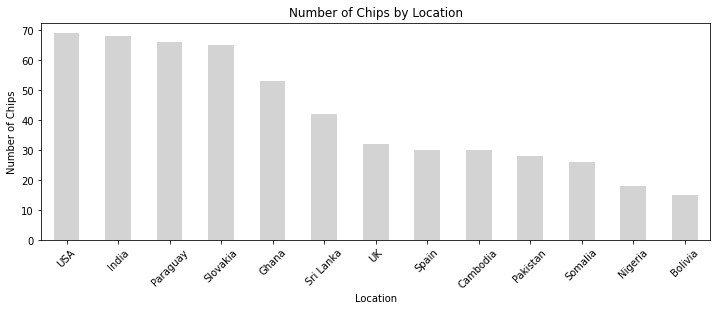

In [28]:
plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar", color="lightgray")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

We have a variety of location that definitely have different types of land, so it will be important to train our models to take that into account and test our models on different locations so that we can find out where needs to be the most improvement.

Some locations have way more chips for floods than others, so that means the data is likely much richer in those areas.

In [29]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year).nunique()
year_counts

,image_id,chip_id,flood_id,polarization,location,scene_start
scene_start,,,,,,
2016,136,68,1,2,1,1
2017,140,70,2,2,2,2
2018,416,208,6,2,6,6
2019,262,131,3,2,3,3
2020,130,65,1,2,1,1


In [30]:
train_metadata.groupby("flood_id").nunique()

,image_id,chip_id,polarization,location,scene_start
flood_id,,,,,
awc,30,15,2,1,1
ayt,36,18,2,1,1
coz,56,28,2,1,1
hbe,138,69,2,1,1
hxu,52,26,2,1,1
jja,132,66,2,1,1
kuo,130,65,2,1,1
pxs,136,68,2,1,1
qus,60,30,2,1,1


The training data cover flood events that occurred between 2016 and 2020. Images for each event were captured on the same day.

# 2. Loading and Exploring Images

Next, we can begin exploring the image data. We'll add a `feature_path` column to our training metadata, which will contain a `Path` object with the full path to a training image. We'll also add a `label_path` column that points to each image's corresponding water label.

## Loading Images and DataFrame

In [31]:
train_metadata.chip_id

0       awc00
1       awc00
2       awc01
3       awc01
4       awc02
        ...  
1079    wvy29
1080    wvy30
1081    wvy30
1082    wvy31
1083    wvy31
Name: chip_id, Length: 1084, dtype: object

In [32]:
train_metadata.chip_id.path.with_suffix(".tif")

0       awc00.tif
1       awc00.tif
2       awc01.tif
3       awc01.tif
4       awc02.tif
          ...    
1079    wvy29.tif
1080    wvy30.tif
1081    wvy30.tif
1082    wvy31.tif
1083    wvy31.tif
Name: chip_id, Length: 1084, dtype: object

In [33]:
list_of_img_paths = list("train_labels" / train_metadata.chip_id.path.with_suffix(".tif").path)
list_of_img_paths[:5]

['train_labels/awc00.tif',
 'train_labels/awc00.tif',
 'train_labels/awc01.tif',
 'train_labels/awc01.tif',
 'train_labels/awc02.tif']

In [34]:
train_metadata["feature_path"] = (
    "train_features" /
    train_metadata.image_id.path.with_suffix(".tif").path
    )

In [35]:
train_metadata["label_path"] = (
    "train_labels" /
    train_metadata.chip_id.path.with_suffix(".tif").path
)

A GeoTIFF is a raster image file that contains geographic metadata describing the location of the image. This metadata can include bounding coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

In [36]:
train_metadata.feature_path[0]

'train_features/awc00_vh.tif'

In [37]:
# Examine an arbitrary image
image_path = train_metadata.feature_path[0]

In [38]:
with rasterio.open(image_path) as img:
  metadata = img.meta
  bounds = img.bounds
  data = img.read(1) # read a single polarization band

In [39]:
metadata

{'count': 1,
 'crs': CRS.from_epsg(32720),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 512,
 'nodata': 0.0,
 'transform': Affine(10.0, 0.0, 314030.0,
       0.0, -10.0, 8585890.0),
 'width': 512}

In [40]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [41]:
data

array([[-16.208015 , -17.71951  , -16.281353 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.3288965, -18.231857 , -16.451893 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.353134 , -16.88831  , -15.585904 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [-15.741662 , -15.230668 , -13.455255 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.498258 , -14.100984 , -13.11027  , ...,   0.       ,
          0.       ,   0.       ],
       [-16.055603 , -14.1121   , -14.76084  , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

We will need to be able to identify pixels with missing data, since we will only be evaluated on predictions made for valid input pixels. The metadata tells us that a value of 0.0 represents missing data for an input image. In rasterio, you can access two different kinds of missing data masks. The first mask is a GDAL-style mask, in which non-zero elements (typically 255) indicate that the corresponding data elements are valid.

In [42]:
with rasterio.open(image_path) as img:
  gdal_mask = img.dataset_mask()

In [43]:
gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

The second mask is a numpy masked array, which has the inverse sense: `True` values indicate that the corresponding data elements are invalid. To load the data as a numpy masked array and access this type of missing data mask, simply pass a `masked` flag to `read`.

In [44]:
with rasterio.open(image_path) as img:
  numpy_mask = img.read(1, masked=True)

In [45]:
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

Pixel values represent energy that was reflected back to the satellite measured in decibels. To better visualize the bands or channels of Sentinel-1 images, we will create a [false color composite](https://earthobservatory.nasa.gov/features/FalseColor) by treating the two bands and their ratio as red, grean, and blue channels, respectively. We will prepare a few helper functions to visualize the data.

In [46]:
# import warnings

# warnings.filterwarnings("ignore")

In [47]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

Let's inspect a few chips and their water labels.

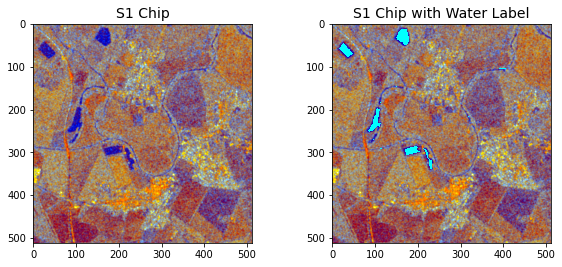

In [48]:
display_random_chip(7)

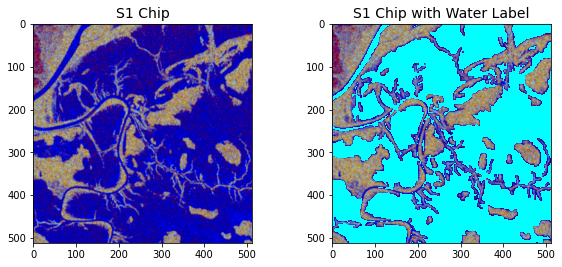

In [49]:
display_random_chip(66)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


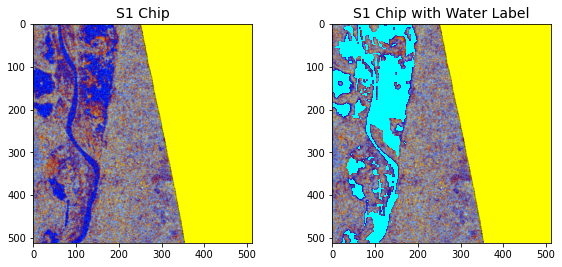

In [50]:
display_random_chip(90)

You'll notice that some images contain high floodwater coverage, while others have little to no coverage. Water spread may be concentrated in one location or spread out, depending on a variety of surface characteristics like topography, terrain, and ground cover. Missing pixels are displayed in yellow.

In [51]:
# Confirming that the images are 512 x 512 pixels.

# examples = [rasterio.open(train_metadata.feature_path[x]) for x in range(len(train_metadata.feature_path))]
# for image in examples:
#     assert image.shape == (512, 512)

# The images are all indeed (512, 512) in shape.
# We are now commenting this code since it takes almost 6 minutes to run and
# we've already answered our question.

## Load External STAC Data



Here we will be using the STAC data from the Microsoft Planetary Computer. With rasterio, we can mask, reproject and regrid distinct datasets. We use these because it will allow our model to better learn from the data. For example, the NASADEM (NASA digital elevation models) gives our satellite images a better elevation representation. 

> A Digital Elevation Model (DEM) is a representation of the bare ground (bare earth) topographic surface of the Earth excluding trees, buildings, and any other surface objects. - https://www.usgs.gov/faqs/what-a-digital-elevation-model-dem?qt-news_science_products=0#qt-news_science_products

> While a digital surface model (DSM) may be useful for landscape modeling, city modeling and visualization applications, a digital terrain model (DTM) is often required for flood or drainage modeling, land-use studies,[1] geological applications, and other applications,[2] and in planetary science. - https://en.wikipedia.org/wiki/Digital_elevation_model

We can reproject our image data onto the elevation levels so that our model has better information for prediction.

In [52]:
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_API)

In [53]:
@dataclass
class ChipInfo:
    """
    Holds information about a training chip, including geospatial info for coregistration
    """

    path: str
    prefix: str
    crs: Any
    shape: List[int]
    transform: List[float]
    bounds: rasterio.coords.BoundingBox
    footprint: Dict[str, Any]


def get_footprint(bounds, crs):
    """Gets a GeoJSON footprint (in epsg:4326) from rasterio bounds and CRS"""
    transformer = pyproj.Transformer.from_crs(crs, "epsg:4326", always_xy=True)
    minx, miny = transformer.transform(bounds.left, bounds.bottom)
    maxx, maxy = transformer.transform(bounds.right, bounds.top)
    return mapping(box(minx, miny, maxx, maxy))


def get_chip_info(chip_path):
    """Gets chip info from a GeoTIFF file"""
    with rasterio.open(chip_path) as ds:
        chip_crs = ds.crs
        chip_shape = ds.shape
        chip_transform = ds.transform
        chip_bounds = ds.bounds

    # Use the first part of the chip filename as a prefix
    prefix = os.path.basename(chip_path).split("_")[0]

    return ChipInfo(
        path=chip_path,
        prefix=prefix,
        crs=chip_crs,
        shape=chip_shape,
        transform=chip_transform,
        bounds=chip_bounds,
        footprint=get_footprint(chip_bounds, chip_crs),
    )

In [54]:
def reproject_to_chip(
    chip_info, input_path, output_path, resampling=Resampling.nearest
):
    """
    Reproject a raster at input_path to chip_info, saving to output_path.

    Use Resampling.nearest for classification rasters. Otherwise use something
    like Resampling.bilinear for continuous data.
    """
    with rasterio.open(input_path) as src:
        kwargs = src.meta.copy()
        kwargs.update(
            {
                "crs": chip_info.crs,
                "transform": chip_info.transform,
                "width": chip_info.shape[1],
                "height": chip_info.shape[0],
                "driver": "GTiff",
            }
        )

        with rasterio.open(output_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=chip_info.transform,
                    dst_crs=chip_info.crs,
                    resampling=Resampling.nearest,
                )

Here we create a ‘VRT’ file, which is merely a ASCII text file describing the transformation and other image metadata. The array values do no need to be duplicated, the VRT file just contains a reference to the local file. This is extremely useful to avoid duplicating lots of data and filling up your computer! - https://geohackweek.github.io/raster/04-workingwithrasters/

In [55]:
def write_vrt(items, asset_key, dest_path):
    """Write a VRT with hrefs extracted from a list of items for a specific asset."""
    hrefs = [pc.sign(item.assets[asset_key].href) for item in items]
    vsi_hrefs = [f"/vsicurl/{href}" for href in hrefs]
    gdal.BuildVRT(dest_path, vsi_hrefs).FlushCache()

In [56]:
def create_chip_aux_file(
    chip_info, collection_id, asset_key, file_name, resampling=Resampling.nearest
):
    """
    Write an auxiliary chip file.

    The auxiliary chip file includes chip_info for the Collection and Asset, and is
    saved in the same directory as the original chip with the given file_name.
    """
    output_path = os.path.join(
        os.path.dirname(chip_info.path), f"{chip_info.prefix}_{file_name}"
    )
    search = catalog.search(collections=[collection_id], intersects=chip_info.footprint)
    items = list(search.get_items())
    print(items)
    print(asset_key)
    with TemporaryDirectory() as tmp_dir:
        vrt_path = os.path.join(tmp_dir, "source.vrt")
        write_vrt(items, asset_key, vrt_path)
        reproject_to_chip(chip_info, vrt_path, output_path, resampling=resampling)
    return output_path

In [57]:
# Define a set of parameters to pass into create_chip_aux_file
aux_file_params = [
    ("nasadem", "elevation", "nasadem.tif", Resampling.bilinear),
    ("jrc-gsw", "extent", "jrc-gsw-extent.tif", Resampling.nearest),
    ("jrc-gsw", "occurrence", "jrc-gsw-occurrence.tif", Resampling.nearest),
    ("jrc-gsw", "recurrence", "jrc-gsw-recurrence.tif", Resampling.nearest),
    ("jrc-gsw", "seasonality", "jrc-gsw-seasonality.tif", Resampling.nearest),
    ("jrc-gsw", "transitions", "jrc-gsw-transitions.tif", Resampling.nearest),
    ("jrc-gsw", "change", "jrc-gsw-change.tif", Resampling.nearest),
]

In [58]:
chip_paths = []
for file_name in os.listdir("train_features"):
    if file_name.endswith("_vv.tif"):
        chip_paths.append(os.path.join("train_features", file_name))
print(f"{len(chip_paths)} chips found.")

542 chips found.


The following code blocks are still being worked on. I may remove this section altogether because I need to install GDAL for it to work and this seems to be an issue with Colab. For this reason, I may need to run the notebook locally instead of Colab if I want to access the Planetary Computer.

In [63]:
# Iterate over the chips and generate all aux input files.
count = len(chip_paths)
for i, chip_path in enumerate(chip_paths):
    if add_planetary_data == True:
        print(f"({i+1} of {count}) {chip_path}")
    chip_info = get_chip_info(chip_path)
    if add_planetary_data == True:
        for collection_id, asset_key, file_name, resampling_method in aux_file_params:
            print(f"  ... Creating chip data for {collection_id} {asset_key}")
            create_chip_aux_file(
                chip_info, collection_id, asset_key, file_name, resampling=resampling_method
            )

(1 of 542) train_features/jja15_vv.tif
(2 of 542) train_features/jja52_vv.tif
(3 of 542) train_features/coz03_vv.tif
(4 of 542) train_features/hbe12_vv.tif
(5 of 542) train_features/hbe27_vv.tif
(6 of 542) train_features/hxu14_vv.tif
(7 of 542) train_features/jja37_vv.tif
(8 of 542) train_features/hbe56_vv.tif
(9 of 542) train_features/jja01_vv.tif
(10 of 542) train_features/jja25_vv.tif
(11 of 542) train_features/kuo18_vv.tif
(12 of 542) train_features/jja16_vv.tif
(13 of 542) train_features/jja06_vv.tif
(14 of 542) train_features/hbe38_vv.tif
(15 of 542) train_features/coz20_vv.tif
(16 of 542) train_features/hxu25_vv.tif
(17 of 542) train_features/hbe42_vv.tif
(18 of 542) train_features/hxu02_vv.tif
(19 of 542) train_features/hbe46_vv.tif
(20 of 542) train_features/jja43_vv.tif
(21 of 542) train_features/hbe34_vv.tif
(22 of 542) train_features/jja51_vv.tif
(23 of 542) train_features/coz11_vv.tif
(24 of 542) train_features/coz01_vv.tif
(25 of 542) train_features/kuo13_vv.tif
(26 of 54

In [65]:
output_path = os.path.join(
        os.path.dirname(chip_info.path), f"{chip_info.prefix}_{file_name}"
    )

In [68]:
hxu12_vv = rasterio.open('train_features/hbe54_vv.tif')
hxu12_nasadem = rasterio.open('train_features/hbe54_jrc-gsw-change.tif')
hxu12_mask = rasterio.open('train_labels/hbe54.tif')

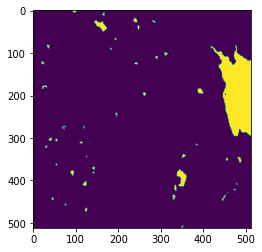

In [70]:
plt.imshow(hxu12_mask.read(1))

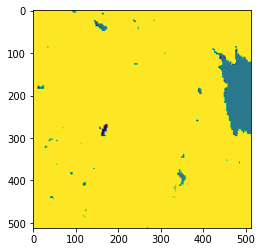

In [71]:
plt.imshow(hxu12_nasadem.read(1))

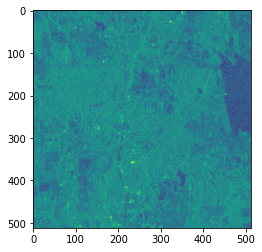

In [72]:
plt.imshow(hxu12_vv.read(1))

# 3. Split the Data

Here we will split the data in a simple way, but if we wanted to really test and improve our model, we would create a set of train/test/validation sets so that we can compare all the models on different slice of data.

Before we start, we'll set a seed for reproducibility. `seed_everything` is a `pytorch_lightning` function that seeds `torch`, `numpy` and `python.random`. Remember that every time you run a random operation, you need to reseed (rerun `seed_everything`) since a function like `random.sample()` will go to the next set of random mix if you run it again without reseeding.

In [ ]:
# set a seed for reproducibility, seeds torch, numpy, python.random
seed_everything(9)

Global seed set to 9


9

In [ ]:
# sample 3 random floods for validation and test sets
flood_ids = train_metadata.flood_id.unique().tolist()
val_test_flood_ids = random.sample(flood_ids, 4)
val_flood_ids = val_test_flood_ids[0:2]
test_flood_ids = val_test_flood_ids[2:]
print(val_flood_ids)
print(test_flood_ids)

['pxs', 'qxb']
['jja', 'hxu']


In [ ]:
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
test = train_metadata[train_metadata.flood_id.isin(test_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_test_flood_ids)]

In [ ]:
test.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
260,hxu00_vh,hxu00,hxu,vh,Somalia,2018-05-07,train_features/hxu00_vh.tif,train_labels/hxu00.tif
261,hxu00_vv,hxu00,hxu,vv,Somalia,2018-05-07,train_features/hxu00_vv.tif,train_labels/hxu00.tif
262,hxu01_vh,hxu01,hxu,vh,Somalia,2018-05-07,train_features/hxu01_vh.tif,train_labels/hxu01.tif
263,hxu01_vv,hxu01,hxu,vv,Somalia,2018-05-07,train_features/hxu01_vv.tif,train_labels/hxu01.tif
264,hxu02_vh,hxu02,hxu,vh,Somalia,2018-05-07,train_features/hxu02_vh.tif,train_labels/hxu02.tif


Since a single input to our model will contain both VV and VH bands, let's identify our input paths by `chip_id`.

In [ ]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [ ]:
# Separate features from labels
val_x = get_paths_by_chip(val)
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

test_x = get_paths_by_chip(test)
test_y = test[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [ ]:
train_x.head(2)

,chip_id,vv_path,vh_path
0,awc00,train_features/awc00_vv.tif,train_features/awc00_vh.tif
1,awc01,train_features/awc01_vv.tif,train_features/awc01_vh.tif


In [ ]:
train_y.head(2)

,chip_id,label_path
0,awc00,train_labels/awc00.tif
1,awc01,train_labels/awc01.tif


In [ ]:
# Confirm approx. 1/4th of images are in the validation and test sets
len(val_x) / (len(val_x) + len(train_x)) * 100

24.444444444444443

The previous cell will depend on our random seed. I used 42 as a random seed and only 11% of the images were in the validation set.

## Check the Images

Here we will load the data from the filenames again to see the mask (label), vh, and vv images.

In [ ]:
filenames = [x.split('.')[0] for x in 
             os.listdir('train_labels/')]
filenames[0:2]

['qxb27', 'pxs46']

In [ ]:
fn = filenames[4]

def plot_mask_vh_vv(start, end):

    for fn in filenames[start:end]:
        
        with rasterio.open(f'train_features/{fn}_vv.tif') as fvv:
            vv = fvv.read(1)
        with rasterio.open(f'train_features/{fn}_vh.tif') as fvh:
            vh = fvh.read(1)
        with rasterio.open(f'train_labels/{fn}.tif') as fmask:
            mask = fmask.read(1)
            
        _, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(mask)
        ax[1].imshow(vh)
        ax[2].imshow(vv)
        plt.show()

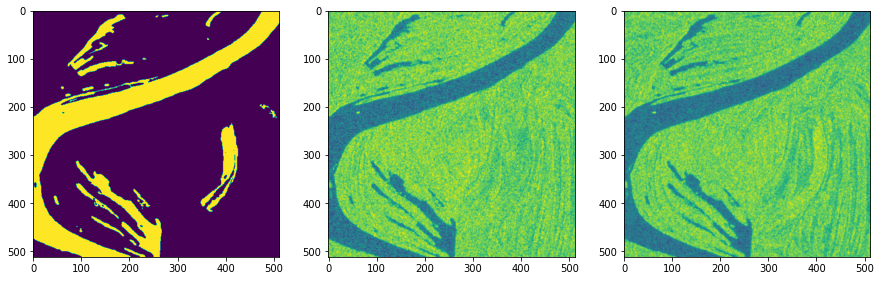

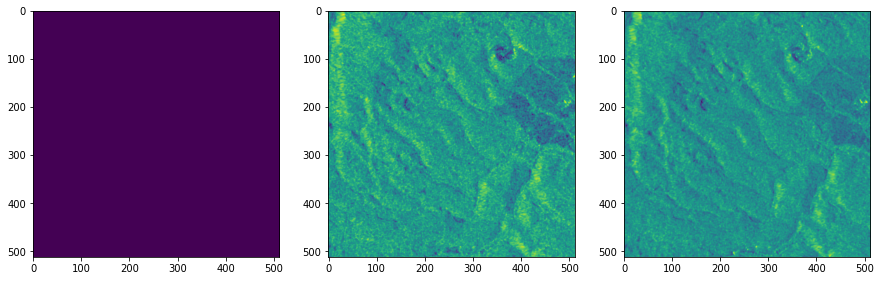

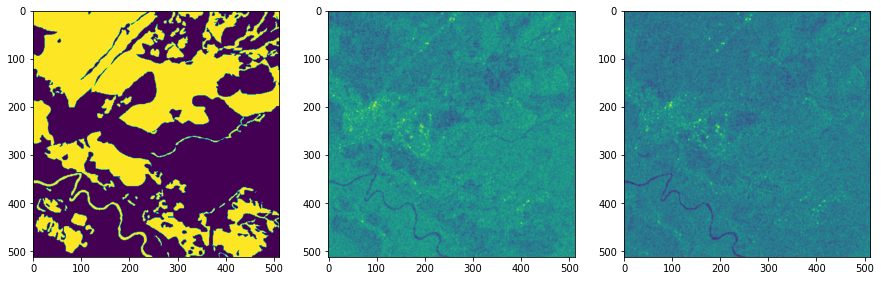

In [ ]:
plot_mask_vh_vv(13, 16)

# 4. Build the Model

The goal of our first pass is to build a relatively simple model that takes radar imagery as input and outputs binary masks that indicate which pixels in a scene contain floodwater. Once we test this basic approach, we can attempt to improve our model by adding additional sophistication and complexity. We will use a lightweight PyTorch wrapper called PyTorch Lightning for this benchmark solution.

Rather than train an entire convolutional neural network (CNN) from scratch, we will tune a U-Net model for semantic segmentation. U-Net was first designed in 2015 to localize abnormalities in biomedical images. By applying a variety of data augmentation techniques, it can achieve high performance using relatively small training datasets. U-Net can be broadly thought of as an encoder network followed by a decoder network, where the encoder can be initialized using a pretrained backbone. For this exercise, we will initialize our encoder using ResNet34. ResNet was prepared by Microsoft Research Asia in 2015 and is pretrained on the ImageNet dataset.

First, we will need to read the training data into memory, convert the data to PyTorch tensors, and serve the data to our model in batches. Luckily, the PyTorch Dataset and DataLoader classes make implementing these complex tasks relatively straightforward. A Dataset object allows us to define custom methods for working with the data, and a DataLoader object parallelizes data loading.



## Creating our Torch Dataset for Model Training

In [ ]:
class FloodDataset(Dataset):
    """
    Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths, y_paths=None, transforms=None):
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        with rasterio.open(img.vv_path) as vv:
            vv_path = vv.read(1)
        with rasterio.open(img.vh_path) as vh:
            vh_path = vh.read(1)
        x_arr = np.stack([vv_path, vh_path], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Apply data augmentation, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare sample dictionary
        sample = {"chip_id": img.chip_id, "chip": x_arr}

        # Load label if available - training only
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            # Apply same data augmentation to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            sample["label"] = y_arr
            
        return sample



Our custom dataset normalizes input pixel values by applying min-max normalization with a minimum of -77 and a maximum of 26.

## Data Augmentations

To prevent overfitting during training, we'll increase the size of our training data by applying a set of data augmentations to our input, including random cropping, random 90 degree rotations, and horizontal and vertical flipping. The image augmentation library albumentations is a helpful resource for this task.

In [ ]:
# These transformations will be passed to our model class
def augment_image(image, mask):

    aug = A.Compose([
        
        A.RandomResizedCrop(512, 512, scale=(0.75, 1.0), p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Blur(p=0.5),
    
    ])

    augmented = aug(image=image, mask=mask)

    return augmented['image'], augmented['mask']

## Metrics and Loss Functions



Next, we will create a custom class to define our training loss function and a helper function to calculate our validation metric, Intersection over Union (IOU).

For training, we will use a standard mixture of 50% cross-entropy loss and 50% dice loss, which improves learning when there are unbalanced classes. Since our images tend to contain more non-water than water pixels, this metric should be a good fit. Broadly speaking, cross-entropy loss evaluates differences between predicted and ground truth pixels and averages over all pixels, while dice loss measures overlap between predicted and ground truth pixels and divides a function of this value by the total number of pixels in both images. This custom class will inherit torch.nn.Module, which is the base class for all neural network modules in PyTorch. A lower XEDiceLoss score indicates better performance.

For validation, we will calculate IOU. As a reminder, IOU represents the size of the intersection divided by the size of the union of pixels. A higher IOU indicates better performance.


In [ ]:
class XEDiceLoss(nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255) # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true) # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true).float()
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

In [ ]:
# class BCEJaccardLoss(nn.module):

#     def __init__

#     def bce_jaccard_loss(y_true, y_pred, smooth=1):

#         intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#         sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
#         jac = (intersection + smooth) / (sum_ - intersection + smooth)
        
#         return (1 - jac) * smooth + nn.BCELoss(y_true, y_pred)

In [ ]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torch.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255) # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

## Our Model Class

In [ ]:
class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        self.architecture = self.hparams.get("architecture", "Unet")
        self.backbone = self.hparams.get("backbone", "efficientnet-b0")
        self.weights = self.hparams.get("weights", "imagenet")
        self.lr = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 40)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 5)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 8)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.x_test = self.hparams.get("x_test")
        self.y_test = self.hparams.get("y_test")
        self.output_path = self.hparams.get("output_path", "model-outputs")
        self.gpus = self.hparams.get("gpus", False)
        self.transform = training_transformations

        # Where final model will be saved
        self.output_path = Path.cwd() / self.output_path
        self.output_path.mkdir(exist_ok=True)

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0

        # Instantiate datasets, model, and trainer params
        self.train_dataset = FloodDataset(
            self.x_train, self.y_train, transforms=self.transform
        )
        self.val_dataset = FloodDataset(self.x_val, self.y_val, transforms=None)
        self.test_dataset = FloodDataset(self.x_test, self.y_test, transforms=None)
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

    # Required LightningModule methods

    def forward(self, image):
        # Forward pass through the network
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Swtich on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpus:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)
        
        # Forward pass
        preds = self.forward(x)
        
        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)
        print('Successfully calculated loss.')
        
        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss",
            xe_dice_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpus:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union
        
        # Log batch IOU
        batch_iou = intersection / union
        # For newer pl versions:
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        return batch_iou
    
    def test_step(self, batch, batch_idx):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpus:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union
        
        # Log batch IOU
        batch_iou = intersection / union
        # For newer pl versions:
        self.log("test_iou", batch_iou)

    def train_dataloader(self):
        # DataLoader class for training
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for training
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )
    
    def test_dataloader(self):
        # DataLoader class for training
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Define Scheduler
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=self.patience
        )

        scheduler = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "xe_dice_loss_step",
        } # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Calculate IOU at the end of epoch
        intersection = self.intersection
        union = self.union
        epoch_iou = intersection / union

        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

        # Log epoch validation IOU
        self.log("val_epoch_iou", epoch_iou, on_epoch=True, prog_bar=True, logger=True)
        return epoch_iou

    ## Convenience Methods ##

    def _prepare_model(self):
        cls = getattr(smp, self.architecture)
        model = cls(
           encoder_name=self.backbone,
           encoder_weights=self.weights,
           in_channels=2,
           classes=2,
        )
        if self.gpus:
            model.cuda()
        return model

    def _get_trainer_params(self):
        # Define callback behavior
        monitoring_value = "val_epoch_iou"
        mode = "max"
        checkpoint_callback = ModelCheckpoint(
            dirpath=self.output_path,
            # save_top_k=1,
            monitor=monitoring_value,
            mode=mode,
            verbose=True,
        )
        early_stop_callback = EarlyStopping(
            monitor=monitoring_value,
            patience=(self.patience * 4),
            mode=mode,
            verbose=True,
        )

        # Specify where Tensorboard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "tensorboard-logs")
        self.log_path.mkdir(exist_ok=True)
        logger = TensorBoardLogger(self.log_path, name="driven-data-comp")
        wandb_logger = WandbLogger(project="Driven-Data-Floodwater-Mapping", entity="effective-altruism-techs")

        wandb_logger.watch(self.model)
        wandb_logger.log_hyperparams(self.hparams)

        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": [logger, wandb_logger],
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.hparams.get("fast_dev_run", False),
            "num_sanity_val_steps": self.hparams.get("val_sanity_checks", 0),
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)
        result = self.trainer.test()
        print(result)

# 5. Train the Model

## Fit Only One Model

### Choosing our hyperparameters for training

In [ ]:
hparams = {
    # Required hparams
    "x_train": train_x,
    "x_val": val_x,
    "y_train": train_y,
    "y_val": val_y,
    # Optional hparams
    "architecture": "Unet",
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 30, # reduced to 10 for quick testing
    "patience": 4,
    "batch_size": 16,
    "num_workers": 3,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

### Model Training

In [ ]:
if h_sweep == False:

    # Init Wandb logger for training
    wandb.init(project=project, entity=entity)

    # Instantiate model
    flood_model = FloodModel(hparams=hparams)

    # Train model
    flood_model.fit()

    print(flood_model.trainer_params["callbacks"][0].best_model_score)

    wandb.finish()

### Test the Model

In [ ]:
if h_sweep == False:
    # need to add test method
    # flood_model.test()
    pass

## Hyperparameter Sweep with Wandb

### Creating yaml file for wandb sweep

In [ ]:
# hyperparameters for future sweeps

#  learning-rate:
#    distribution: uniform
#    min: 0
#    max: 0.1
#  batch_size:
#    distribution: q_log_uniform
#    q: 1
#    min: {batch_log_min}
#    max: {batch_log_max}

# early_terminate:
#    type: hyperband
#    s: 2
#    eta: 3
#    max_iter: 27

We create our yaml file for the hyperparameter sweep below:

In [ ]:
import yaml
import math

batch_log_min = math.log(8)
batch_log_max = math.log(64)
available_gpu = torch.cuda.is_available()

sweep_yaml = f"""
method: grid
metric:
 name: val_iou
 goal: maximize
parameters:
 architecture: 
   values: ["Unet"]
 backbone: 
   values: ["resnet34", "efficientnet-b0", "efficientnet-b2"]
 weights: 
   value: imagenet
 optimizer: 
   value: adam
 lr:
   value: 0.001
 batch_size: 
   value: 8
 min_epochs: 
   value: 6
 max_epochs: 
   value: 50
 patience: 
   value: 5
 val_sanity_checks: 
   value: 0
 fast_dev_run: 
   value: False
 output_path: 
   value: model-outputs
 gpu: 
   value: True
 num_workers: 
   value: 0
"""

with open('initial_grid_sweep.yaml', 'w') as file:
    yaml.dump(sweep_yaml, file, default_style='|')

In [ ]:
import yaml

with open("initial_grid_sweep.yaml", 'r') as file:
    sweep_string = yaml.safe_load(file)

sweep_config = yaml.safe_load(sweep_string)

Let's check to see the yaml file safely loaded as a dictionary:

In [ ]:
sweep_config.get('parameters')

{'architecture': {'values': ['Unet',
   'UnetPlusPlus',
   'DeepLabV3',
   'DeepLabV3Plus']},
 'backbone': {'values': ['resnet34', 'xception', 'efficientnet-b0']},
 'batch_size': {'value': 8},
 'fast_dev_run': {'value': False},
 'gpu': {'value': True},
 'lr': {'values': [0.001, 0.0003, 0.0001]},
 'max_epochs': {'value': 50},
 'min_epochs': {'value': 6},
 'num_workers': {'value': 0},
 'optimizer': {'value': 'adam'},
 'output_path': {'value': 'model-outputs'},
 'patience': {'value': 5},
 'val_sanity_checks': {'value': 0},
 'weights': {'value': 'imagenet'}}

We create sweep id based on our configuration.

In [ ]:
if h_sweep == True:
    sweep_id = wandb.sweep(sweep_config, project=project, entity=entity)

Create sweep with ID: 11n8jnr5
Sweep URL: https://wandb.ai/effective-altruism-techs/Driven-Data-Floodwater-Mapping/sweeps/11n8jnr5


## Instantiate and Fit Models

### Model Training with Hyperparameter Sweep

In [ ]:
model_hparams = []
model_scores = []
model_paths = []

def sweep_iteration(config=None, model_scores=model_scores, model_paths=model_paths):

    with wandb.init(config=config) as run:

        # set up W&B logger
        wandb_logger = WandbLogger()

        print(wandb.config)
        # instantiate model - note how we refer to sweep parameters with wandb.config
        flood_model = FloodModel(hparams=wandb.config)

        flood_model.fit()

        print(wandb.config)

        model_hparams.append(str(wandb.config))
        model_scores.append(flood_model.trainer_params["callbacks"][0].best_model_score)
        model_paths.append(flood_model.trainer_params["callbacks"][0].best_model_path)

We run an agent that will iterate over the sweep parameters.

In [ ]:
if h_sweep == True:
    wandb.agent(sweep_id, function=sweep_iteration)

wandb: Agent Starting Run: 29jksu7y with config:
wandb: 	architecture: Unet
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'Unet', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /content/model-outputs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' wa

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121bc95910>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121cce0c10>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121bc95d90>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121bc95fd0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.188
Epoch 0, global step 45: val_epoch_iou reached 0.18769 (best 0.18769), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.069 >= min_delta = 0.0. New best score: 0.256
Epoch 1, global step 91: val_epoch_iou reached 0.25637 (best 0.25637), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.260
Epoch 2, global step 137: val_epoch_iou reached 0.26027 (best 0.26027), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.275
Epoch 8, global step 413: val_epoch_iou reached 0.27479 (best 0.27479), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.276
Epoch 19, global step 919: val_epoch_iou reached 0.27622 (best 0.27622), saving model to "/content/model-outputs/epoch=19-step=919.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.279
Epoch 25, global step 1195: val_epoch_iou reached 0.27872 (best 0.27872), saving model to "/content/model-outputs/epoch=25-step=1195.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.281
Epoch 28, global step 1333: val_epoch_iou reached 0.28094 (best 0.28094), saving model to "/content/model-outputs/epoch=28-step=1333.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.281. Signaling Trainer to stop.
Epoch 48, global step 2253: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▆▆▄▆▆▆█▆▆▅▆▆▅▅▆██▇▆▆█▆█▇█▆▃▄▄▆█▇▅▅▇▇▄▆▇
iou_step,▅█▂▃▄▇▃▇▇▁▄▂█▇█▂▄▄▇▃▇▇▁▄▂█▇█▁▄▄▇▄▇▇▁▄▁█▇
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▇▄▄▄▄▄▄█▄▅▅
val_epoch_iou,▁▆▆▄▆▆▆█▆▆▅▆▆▅▅▆██▇▆▆█▆█▇█▆▃▄▃▆█▇▅▅▇▇▄▆▇
val_loss_epoch,█▂▂▄▂▂▂▁▂▂▃▂▂▂▂▂▁▁▂▂▂▁▂▁▂▁▂▃▃▃▂▂▁▃▂▂▂▃▂▂
val_loss_step,▅▃▆█▅▆▇▃▃██▄▁▃▃▆█▅▇▇▃▂█▇▄▁▃▃▇█▅▇▆▃▂██▆▁▃
xe_dice_loss_epoch,█▃▄▄▃▂▂▁▁▃▄▂▃▃▃▄▃▃▂▅▁▂▂▄▄▅▃▃▂▃▄▅▂▁▅▃▅▂▃▂
xe_dice_loss_step,▂▄▄▄▂▄▆▆█▄▂▃▆▇█▇▅▆▆▄▇▅▄▄▃▇▄▄▄▄▂▃▅█▇▁█▄▄█
epoch,48
iou_epoch,0.25409


wandb: Agent Starting Run: 8s4zb4e8 with config:
wandb: 	architecture: Unet
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'Unet', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121c409550>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121c4091d0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121bbb6510>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121c409c10>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.152
Epoch 0, global step 45: val_epoch_iou reached 0.15173 (best 0.15173), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.053 >= min_delta = 0.0. New best score: 0.205
Epoch 1, global step 91: val_epoch_iou reached 0.20492 (best 0.20492), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.017 >= min_delta = 0.0. New best score: 0.222
Epoch 3, global step 183: val_epoch_iou reached 0.22164 (best 0.22164), saving model to "/content/model-outputs/epoch=3-step=183.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.016 >= min_delta = 0.0. New best score: 0.237
Epoch 12, global step 597: val_epoch_iou reached 0.23748 (best 0.23748), saving model to "/content/model-outputs/epoch=12-step=597.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.039 >= min_delta = 0.0. New best score: 0.276
Epoch 15, global step 735: val_epoch_iou reached 0.27616 (best 0.27616), saving model to "/content/model-outputs/epoch=15-step=735.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.276. Signaling Trainer to stop.
Epoch 35, global step 1655: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
iou_epoch,▁▄▄▅▅▅▃▄▅▄▄▅▆▂▃█▄▄▄▅▅▅▅▃▂▅▇▅▆▆▇▅▆▅▄▅
iou_step,▂▄▅▁▅▅▆▅▁▄▇▅▇▅▃▂▁▁▅▇▆█▄▄▅▁▄▄▅▇▁▄█▆█▅▄▅▁▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄███
val_epoch_iou,▁▄▄▅▅▅▂▄▅▃▄▄▆▁▃█▃▄▄▅▅▅▄▃▂▅▇▄▅▆▇▅▆▅▄▄
val_loss_epoch,▁▇▇▆▆▇▇▆▆▇▇▇▆█▆▃▆▇▆▆▆▆▇▇▆▆▄▆▆▆▄▅▅▅▆▆
val_loss_step,▃▅▄▇▂▄▂▃█▃▂▅▄▃▅▃▆█▄▁▃▃▃▄▄▇▃▄▂▁█▃▁▄▃▂▄▁▆▂
xe_dice_loss_epoch,█▃▄▃▄▄▃▁▂▃▃▄▃▃▅▃▄▅▃▄▄▃▄▂▄▄▅▄▄▃▄▁▄▃▄▃
xe_dice_loss_step,▅▃▇▃█▃█▃▃█▇█▂▂▃██▃▃▂▂▄▂▆▅▇▁▃▃▅█▂▂
epoch,35
iou_epoch,0.19617


wandb: Agent Starting Run: e379jhd0 with config:
wandb: 	architecture: Unet
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'Unet', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121c027110>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121c027550>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121c482f50>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121bfe7c90>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.192
Epoch 0, global step 45: val_epoch_iou reached 0.19205 (best 0.19205), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 91: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.195
Epoch 2, global step 137: val_epoch_iou reached 0.19535 (best 0.19535), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.202
Epoch 5, global step 275: val_epoch_iou reached 0.20181 (best 0.20181), saving model to "/content/model-outputs/epoch=5-step=275.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.202. Signaling Trainer to stop.
Epoch 25, global step 1195: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▆▁▆▂▆█▅▆▅▆▁▅▃▃▅▇▇▃▄▅▇▄▅▆▄█
iou_step,▅▄▅▄▁▃▇▄▅▄▆▃█▄▅▇▅▃█▄▃▆▆▃█▅▃▆▆▃▁▅▄▇▆▁▁▄▄▇
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▄▂▃▅▃▃▃▃▃▃▄▄▄▄▇▄▄█▄▅▅▅▅▅▅▅▅▆
val_epoch_iou,▆▁▇▂▆█▅▆▅▆▁▅▃▃▅▇▇▃▄▆▇▅▅▆▄█
val_loss_epoch,▁█▂▇▃▁▄▂▄▃█▄▅▅▄▁▁▆▃▂▂▃▄▂▅▂
val_loss_step,▃▄▃▅█▆▂▅▃▅▃▆▁▅▃▂▃▆▁▅▅▃▃▆▁▄▅▃▃▆█▄▅▃▃██▄▅▂
xe_dice_loss_epoch,█▅▂▃▃▄▅▄▄▆▆▄▂▂▃▅▁▂▄▄▅▄▄▂▂▄
xe_dice_loss_step,▁▂▂▇▃▄▂▇▃▂▂█▂▂▅▃▅▇█▄▄▂▄
epoch,25
iou_epoch,0.18973


wandb: Agent Starting Run: tt1ttec5 with config:
wandb: 	architecture: Unet
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'Unet', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


  0%|          | 0.00/87.4M [00:00<?, ?B/s]

wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121bcaf950>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121c4724d0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121bcb9a50>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121bcb98d0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.233
Epoch 0, global step 45: val_epoch_iou reached 0.23292 (best 0.23292), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.041 >= min_delta = 0.0. New best score: 0.274
Epoch 1, global step 91: val_epoch_iou reached 0.27379 (best 0.27379), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.280
Epoch 2, global step 137: val_epoch_iou reached 0.28022 (best 0.28022), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.042 >= min_delta = 0.0. New best score: 0.323
Epoch 3, global step 183: val_epoch_iou reached 0.32260 (best 0.32260), saving model to "/content/model-outputs/epoch=3-step=183.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.323. Signaling Trainer to stop.
Epoch 23, global step 1103: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
iou_epoch,▁▅▅█▆▅▇▄▇▂▅▃▃▅▆▆█▄▇▅▆█▅▆
iou_step,▃▅▇▆▆█▅▃▄▃▆▃▁▃▆▇▂▆█▁▃▄▇▆▃█▄▆▃▂▆▃▁▃▆▇▆▆█▄
trainer/global_step,▁▁▁▂▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▄▄▄▄▇▄▄█▄▄▅▅▅▅▅▅
val_epoch_iou,▁▄▅█▆▄▆▄▇▂▅▃▂▅▆▆█▃▆▄▅█▄▆
val_loss_epoch,█▄▄▂▂▄▂▄▃▆▃▄▅▄▃▂▁▅▃▃▂▁▄▃
val_loss_step,▇▄▁▃▃▃▃▆▅▃▃▆█▅▃▂▄▃▂█▆▅▁▃▆▂▄▃▅▄▃▆█▆▃▁▃▃▂▃
xe_dice_loss_epoch,█▂▃▂▂▂▃▃▃▂▂▁▃▃▄▃▂▁▃▂▂▃▁▂
xe_dice_loss_step,▆▆▁▆▂▆▅▄▃▂▃▃▆▅▃██▃▇▆▅▂
epoch,23
iou_epoch,0.28842


wandb: Agent Starting Run: 0kgx0saw with config:
wandb: 	architecture: Unet
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'Unet', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a1c58e10>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121bf229d0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121bba85d0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f122d3eec50>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.274
Epoch 0, global step 45: val_epoch_iou reached 0.27421 (best 0.27421), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 91: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.030 >= min_delta = 0.0. New best score: 0.304
Epoch 2, global step 137: val_epoch_iou reached 0.30435 (best 0.30435), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.023 >= min_delta = 0.0. New best score: 0.327
Epoch 3, global step 183: val_epoch_iou reached 0.32748 (best 0.32748), saving model to "/content/model-outputs/epoch=3-step=183-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.327. Signaling Trainer to stop.
Epoch 23, global step 1103: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
iou_epoch,▁▁▅█▇▇▅▅▄▃▆█▆▂▇▆▇▆▃▇▅▄▇▂
iou_step,▃▆▇▆▆█▇▃▄█▆▂▁▅▆▇▅▆█▁▃▄▇▆▂█▆▆▄█▆▂▁▃▆▇▆▆█▄
trainer/global_step,▁▁▁▂▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▄▄▄▄▇▄▄█▄▄▅▅▅▅▅▅
val_epoch_iou,▁▁▅█▇▇▅▅▄▂▆█▅▂▇▆▇▆▂▇▅▄▇▂
val_loss_epoch,▂█▁▂▂▂▄▄▆▅▄▂▁▇▃▅▄▃▄▄▄█▅▇
val_loss_step,▇▃▃▄▃▄▂▇▆▁▄▇█▄▄▂▃▃▄█▇▆▃▄▇▄▃▃▆▁▃▆█▇▄▃▅▃▄▅
xe_dice_loss_epoch,█▂▃▄▅▄▄▃▁▄▅▄▇▄▅▃▃▂▃▂▄▂▃▄
xe_dice_loss_step,▂▇▄▇▄▄▇▂▁▅▃██▅█▃█▂▅█▃▂
epoch,23
iou_epoch,0.26535


wandb: Agent Starting Run: 9x9n4rlv with config:
wandb: 	architecture: Unet
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'Unet', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121ae20e10>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121ab6b710>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121b1a02d0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121ae47dd0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.207
Epoch 0, global step 45: val_epoch_iou reached 0.20693 (best 0.20693), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.211
Epoch 1, global step 91: val_epoch_iou reached 0.21096 (best 0.21096), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.013 >= min_delta = 0.0. New best score: 0.224
Epoch 3, global step 183: val_epoch_iou reached 0.22378 (best 0.22378), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.016 >= min_delta = 0.0. New best score: 0.239
Epoch 4, global step 229: val_epoch_iou reached 0.23943 (best 0.23943), saving model to "/content/model-outputs/epoch=4-step=229.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.239. Signaling Trainer to stop.
Epoch 24, global step 1149: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
iou_epoch,▃▄▁▆█▆▇▄▄▇▃▄▅▃▅▅▄▅▆▄▅▃▅▆▆
iou_step,▄▅█▅▇▆▆▆▄▅▇▁▁▄▄█▅▁▅▆▆█▃▇▆▁▄▄▆▅▁▁▅▆▇▅▇▆▆▆
trainer/global_step,▁▁▁▂▁▂▂▂▂▂▂▂▂▂▄▃▃▃▃▃▃▃▃▄▄▄▄▇▄▄█▄▅▅▅▅▅▅▅▅
val_epoch_iou,▃▄▁▆█▆▇▄▄▇▃▄▅▃▅▅▄▅▆▅▅▃▅▆▆
val_loss_epoch,▆▆█▃▁▄▃▅▅▂▄▄▄▆▅▄▄▄▄▄▃▅▃▃▁
val_loss_step,▅▅▂▆▂▆▃▄▆▄▁██▅▆▁▆█▆▄▄▂▅▂▆█▅▆▄▆██▄▄▂▆▁▆▃▄
xe_dice_loss_epoch,█▂▁▃▄▃▃▂▁▂▂▃▃▃▄▅▄▂▂▂▃▄▄▃▂
xe_dice_loss_step,█▄▂▂▂▃▆▅▂▇▃▅▆██▃▅▁▃▂▄▂▃
epoch,24
iou_epoch,0.21391


wandb: Agent Starting Run: 9ttba9vf with config:
wandb: 	architecture: Unet
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'Unet', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121c2ea610>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121c2ea710>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121c2ea990>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121c2ea090>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.000
Epoch 0, global step 45: val_epoch_iou reached 0.00000 (best 0.00000), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 1, global step 91: val_epoch_iou reached 0.00001 (best 0.00001), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.026 >= min_delta = 0.0. New best score: 0.026
Epoch 2, global step 137: val_epoch_iou reached 0.02565 (best 0.02565), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.046 >= min_delta = 0.0. New best score: 0.072
Epoch 3, global step 183: val_epoch_iou reached 0.07196 (best 0.07196), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.076
Epoch 4, global step 229: val_epoch_iou reached 0.07577 (best 0.07577), saving model to "/content/model-outputs/epoch=4-step=229-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.097 >= min_delta = 0.0. New best score: 0.173
Epoch 7, global step 367: val_epoch_iou reached 0.17256 (best 0.17256), saving model to "/content/model-outputs/epoch=7-step=367.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.165 >= min_delta = 0.0. New best score: 0.337
Epoch 8, global step 413: val_epoch_iou reached 0.33720 (best 0.33720), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.033 >= min_delta = 0.0. New best score: 0.370
Epoch 9, global step 459: val_epoch_iou reached 0.36993 (best 0.36993), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.027 >= min_delta = 0.0. New best score: 0.397
Epoch 10, global step 505: val_epoch_iou reached 0.39669 (best 0.39669), saving model to "/content/model-outputs/epoch=10-step=505.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.020 >= min_delta = 0.0. New best score: 0.416
Epoch 11, global step 551: val_epoch_iou reached 0.41624 (best 0.41624), saving model to "/content/model-outputs/epoch=11-step=551.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.417
Epoch 13, global step 643: val_epoch_iou reached 0.41711 (best 0.41711), saving model to "/content/model-outputs/epoch=13-step=643.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.421
Epoch 17, global step 827: val_epoch_iou reached 0.42092 (best 0.42092), saving model to "/content/model-outputs/epoch=17-step=827.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.421. Signaling Trainer to stop.
Epoch 37, global step 1747: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
iou_epoch,▁▁▁▂▂▂▂▄▆▇▇███████████████████████████
iou_step,▁▁▁▁▂▁▂▁▃▄▇▂▂▅▅▄▂▄▅▄▆▄▅▅▆▄▅▅▃▆▅█▃▆▅█▃▂▅█
trainer/global_step,▁▁▁▁▁▁▂▂▃▃▃▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄███▄▅
val_epoch_iou,▁▁▁▂▂▂▂▄▇▇████████████████████████████
val_loss_epoch,▃▄▆██▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▅▅▇█▇█▇▆▃▃▂▄▄▂▂▂▄▂▂▂▂▂▂▂▂▂▂▂▄▁▂▁▄▂▂▁▃▄▂▁
xe_dice_loss_epoch,█▃▆▂▄▁▄▂▂▃▃▃▇▄▂▂▃▃▃▄▅▅▃▂▄▅▃▃▄▃▄▃▃▄▂▃▁▄
xe_dice_loss_step,▁▇▃▂▃▇█▄▆▄▅▆▄▃▅▄▄▁▇▇▅▃▆▂██▂▇▄▅▇▇▇▂
epoch,37
iou_epoch,0.38525


wandb: Agent Starting Run: hf2jegos with config:
wandb: 	architecture: Unet
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'Unet', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}
{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a22c7f90>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a2ba7810>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121c40e890>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a2ba7d50>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}



  | Name  | Type | Params
-------------------------------
0 | model | Unet | 6.3 M 
-------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.005    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.005
Epoch 0, global step 45: val_epoch_iou reached 0.00491 (best 0.00491), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.099 >= min_delta = 0.0. New best score: 0.103
Epoch 1, global step 91: val_epoch_iou reached 0.10343 (best 0.10343), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.118
Epoch 2, global step 137: val_epoch_iou reached 0.11825 (best 0.11825), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.122
Epoch 3, global step 183: val_epoch_iou reached 0.12231 (best 0.12231), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.126
Epoch 7, global step 367: val_epoch_iou reached 0.12578 (best 0.12578), saving model to "/content/model-outputs/epoch=7-step=367.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.087 >= min_delta = 0.0. New best score: 0.212
Epoch 8, global step 413: val_epoch_iou reached 0.21230 (best 0.21230), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.060 >= min_delta = 0.0. New best score: 0.272
Epoch 9, global step 459: val_epoch_iou reached 0.27225 (best 0.27225), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.035 >= min_delta = 0.0. New best score: 0.307
Epoch 10, global step 505: val_epoch_iou reached 0.30721 (best 0.30721), saving model to "/content/model-outputs/epoch=10-step=505.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.314
Epoch 11, global step 551: val_epoch_iou reached 0.31374 (best 0.31374), saving model to "/content/model-outputs/epoch=11-step=551.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.319
Epoch 12, global step 597: val_epoch_iou reached 0.31897 (best 0.31897), saving model to "/content/model-outputs/epoch=12-step=597.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.325
Epoch 13, global step 643: val_epoch_iou reached 0.32521 (best 0.32521), saving model to "/content/model-outputs/epoch=13-step=643.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.325. Signaling Trainer to stop.
Epoch 33, global step 1563: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
iou_epoch,▁▃▄▄▃▃▂▄▅▇████████████████████████
iou_step,▁▂▂▂▂▄▂▂▁▂▅▆▆█▅▅▆▃▃▅▇▇▃▆▆▇▇▇▅▅▆▃▃▅▇▆▃▆▆▆
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▂▂▂▂▃▃▃▃▃▃▃▃▆▄▄▄▄▄▄▄█▄▅▅▅▅▅▅▅▅
val_epoch_iou,▁▃▃▄▃▃▂▄▆▇████████████████████████
val_loss_epoch,▂▁▆█▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▂▂▂█▆█▅▃▃▂▂▁▁▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▂▂▂▂▂▁▂▂▂▁▂
xe_dice_loss_epoch,█▃▃▃▅▃▃▄▅▂▅▃▃▃▄▄▅▂▂▃▄▂▁▃▂▃▂▅▂▂▂▁▂▂
xe_dice_loss_step,▆▇▅▆▁▅▂▂▅█▄▅▇▅▂▂▁▅▃▆▄▄▁▂▇▇▃▂▅█▆
epoch,33
iou_epoch,0.29786


wandb: Agent Starting Run: 7hg61bv5 with config:
wandb: 	architecture: Unet
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'Unet', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}
{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121c319510>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121cd99410>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121c319b90>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121d070910>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}



  | Name  | Type | Params
-------------------------------
0 | model | Unet | 6.3 M 
-------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.005    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.034
Epoch 0, global step 45: val_epoch_iou reached 0.03378 (best 0.03378), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.072 >= min_delta = 0.0. New best score: 0.106
Epoch 1, global step 91: val_epoch_iou reached 0.10616 (best 0.10616), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.031 >= min_delta = 0.0. New best score: 0.137
Epoch 2, global step 137: val_epoch_iou reached 0.13695 (best 0.13695), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.013 >= min_delta = 0.0. New best score: 0.150
Epoch 6, global step 321: val_epoch_iou reached 0.14984 (best 0.14984), saving model to "/content/model-outputs/epoch=6-step=321.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.018 >= min_delta = 0.0. New best score: 0.168
Epoch 7, global step 367: val_epoch_iou reached 0.16751 (best 0.16751), saving model to "/content/model-outputs/epoch=7-step=367.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.013 >= min_delta = 0.0. New best score: 0.181
Epoch 8, global step 413: val_epoch_iou reached 0.18053 (best 0.18053), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.016 >= min_delta = 0.0. New best score: 0.196
Epoch 9, global step 459: val_epoch_iou reached 0.19638 (best 0.19638), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.199
Epoch 15, global step 735: val_epoch_iou reached 0.19949 (best 0.19949), saving model to "/content/model-outputs/epoch=15-step=735-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.199. Signaling Trainer to stop.
Epoch 35, global step 1655: val_epoch_iou was not in top 1


{'architecture': 'Unet', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
iou_epoch,▁▄▅▅▅▅▆▇▇███████████████████████████
iou_step,▁▃▂▁▅▃▄▆▂▅▆▄▃█▄▆▂▂▅▆▇▃▆▄▄▂█▅▆▇▂▅▆▄▃█▄▆▂█
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄███
val_epoch_iou,▁▄▅▅▅▅▆▇▇███████████████████▇███████
val_loss_epoch,▁▂▄▆█▆▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
val_loss_step,▂▃▅▇▅▇█▃▆▃▂▅▅▁▅▂▆▆▃▂▁▅▃▅▅▆▁▃▂▁▆▄▃▅▅▁▅▂▆▁
xe_dice_loss_epoch,▇▆▄▅▄▆█▆▁▆▆▇▇▆▃▇▅▇▄▆▄▇▆▄█▄▆▂▁▂▂▄▆▆▁▅
xe_dice_loss_step,▇▃█▇▇▃█▄▅█▃▆▃▅▆▅▅█▂█▃▆▁▃▃▆▅▃▇▇▂▄▃
epoch,35
iou_epoch,0.18751


wandb: Agent Starting Run: kj5gkca2 with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'UnetPlusPlus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a179fa90>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a17b6ad0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a2c87c90>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a179fd90>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.171
Epoch 0, global step 45: val_epoch_iou reached 0.17082 (best 0.17082), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.147 >= min_delta = 0.0. New best score: 0.318
Epoch 1, global step 91: val_epoch_iou reached 0.31759 (best 0.31759), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.319
Epoch 3, global step 183: val_epoch_iou reached 0.31928 (best 0.31928), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.320
Epoch 4, global step 229: val_epoch_iou reached 0.32012 (best 0.32012), saving model to "/content/model-outputs/epoch=4-step=229-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.321
Epoch 8, global step 413: val_epoch_iou reached 0.32063 (best 0.32063), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.321
Epoch 20, global step 965: val_epoch_iou reached 0.32144 (best 0.32144), saving model to "/content/model-outputs/epoch=20-step=965.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.321
Epoch 30, global step 1425: val_epoch_iou reached 0.32147 (best 0.32147), saving model to "/content/model-outputs/epoch=30-step=1425.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.322
Epoch 34, global step 1609: val_epoch_iou reached 0.32227 (best 0.32227), saving model to "/content/model-outputs/epoch=34-step=1609.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁█▆█▇▇▇█▆▆▇▆▇▅█▃█▆▄▇▄▆█▃█▆▇▇▇▃▅▇▃▇▆▆▅▇█▅
iou_step,▄▅▁▂▃▅▇▅▄▁▃█▅▄▄▁▂█▅▇▅▁▁▃▄▅▅▄▁▂▇▅▇▅▁▂▃▅█▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁█▇██▇▇█▆▇▇▇▇▅█▃█▇▄▇▄▆█▃█▆███▃▆▇▃▇▆▇▅▇█▅
val_loss_epoch,█▂▂▂▂▁▂▂▂▂▂▃▂▃▂▄▂▃▄▂▄▂▁▄▁▃▁▂▁▅▃▂▄▂▃▂▂▂▁▃
val_loss_step,▅▃▇█▆▅▂▃▄▇▆▁▄▄▄▇█▁▅▂▃▇▇▆▅▄▄▅▇█▃▄▂▃▇█▆▅▁▃
xe_dice_loss_epoch,█▄▂▄▄▅▂▃▅▂▅▄▅▄▄▃▂▄▁▆▄▃▅▃▃▄▅▃▅▂▃▃▆▆▄▅▆▃▄▄
xe_dice_loss_step,▂▃▅█▄▃▆▃▅█▃▆▇▃▁▃▁▁▁▃▂▂▃▁▄▇▆▇▂▄▃▆▇▃▇▃▇▇▂▃
epoch,49
iou_epoch,0.21988


wandb: Agent Starting Run: z8e4wn1r with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'UnetPlusPlus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121bff4a90>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a2c90790>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121ad466d0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a22f1650>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.214
Epoch 0, global step 45: val_epoch_iou reached 0.21449 (best 0.21449), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.113 >= min_delta = 0.0. New best score: 0.328
Epoch 1, global step 91: val_epoch_iou reached 0.32769 (best 0.32769), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.332
Epoch 5, global step 275: val_epoch_iou reached 0.33152 (best 0.33152), saving model to "/content/model-outputs/epoch=5-step=275-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.342
Epoch 10, global step 505: val_epoch_iou reached 0.34158 (best 0.34158), saving model to "/content/model-outputs/epoch=10-step=505.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.342
Epoch 11, global step 551: val_epoch_iou reached 0.34187 (best 0.34187), saving model to "/content/model-outputs/epoch=11-step=551.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.033 >= min_delta = 0.0. New best score: 0.375
Epoch 12, global step 597: val_epoch_iou reached 0.37506 (best 0.37506), saving model to "/content/model-outputs/epoch=12-step=597.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.375. Signaling Trainer to stop.
Epoch 32, global step 1517: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
iou_epoch,▁▆▅▆▃▆▆▆▆▅▇▇█▇▆▇█▆█▇▅▇▇▅▄▆▆▇▆▇▃▅▇
iou_step,▃▄▆▆▁▃▄▆▂▁▃▆▆▂▁▆▇▆█▆▆▇▆█▇▄█▆█▃▄▅▂▁▃▄▆▁▁▆
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄█▄▅▅▅▅▅▅▅
val_epoch_iou,▁▆▄▅▃▆▆▆▆▄▇▇█▇▆▇█▆█▇▅▇▇▅▄▆▆▇▆▇▃▅▇
val_loss_epoch,█▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▂▂▂▂▂▂▂▁▂▂▂
val_loss_step,█▄▂▄▆▆▄▂▆▆▆▂▃▆▆▃▂▃▂▂▃▂▃▂▂▄▁▃▂▆▄▂▆▆▆▄▃▆▆▃
xe_dice_loss_epoch,█▄▂▂▁▂▂▃▃▄▄▃▅▂▄▄▅▁▂▃▁▁▁▄▃▅▂▄▃▁▂▅▅
xe_dice_loss_step,▂▃▃█▃▂▁▄▄▇▃▂▄▄▃▂▅█▅▆▃▇▃█▄▃▃▄▇▄
epoch,32
iou_epoch,0.32705


wandb: Agent Starting Run: uoyutijv with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'UnetPlusPlus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a1e7b610>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a14854d0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a1fca1d0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a1649810>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.246
Epoch 0, global step 45: val_epoch_iou reached 0.24619 (best 0.24619), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.057 >= min_delta = 0.0. New best score: 0.303
Epoch 1, global step 91: val_epoch_iou reached 0.30345 (best 0.30345), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.306
Epoch 9, global step 459: val_epoch_iou reached 0.30564 (best 0.30564), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.310
Epoch 22, global step 1057: val_epoch_iou reached 0.30957 (best 0.30957), saving model to "/content/model-outputs/epoch=22-step=1057.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.310
Epoch 30, global step 1425: val_epoch_iou reached 0.31026 (best 0.31026), saving model to "/content/model-outputs/epoch=30-step=1425.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.311
Epoch 31, global step 1471: val_epoch_iou reached 0.31134 (best 0.31134), saving model to "/content/model-outputs/epoch=31-step=1471.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.318
Epoch 33, global step 1563: val_epoch_iou reached 0.31834 (best 0.31834), saving model to "/content/model-outputs/epoch=33-step=1563.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▇▆▅▅▅▅▇▃▆▆▅▆▆▄▆▂▅▇▇▅▆▆▅▇▇▅█▅▃▆▃▅▅█▆▇▄▆▅
iou_step,▄▇▂▄▅▆▇▇▅▁▅▇▆▆▆▂▄▇▆█▇▂▁▅▆▇▅▆▁▄█▇▇▇▂▄▅▅▇▇
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁▇▅▅▅▅▄▆▃▆▆▅▆▆▄▆▂▅▇▇▄▆▆▅▇▇▅█▄▃▆▂▅▅█▆▇▄▆▅
val_loss_epoch,█▄▆▇▇▆▅▃▄▃▅▅▅▃▆▃▇▆▃▄▆▆▂▃▁▂▃▃▅▆▄▄▃▆▃▂▃▆▃▃
val_loss_step,▅▃▆▅▅▅▃▃▄█▅▁▄▄▄▆▅▁▅▂▃▆█▅▅▄▄▅█▅▁▃▃▃▆▅▅▅▂▃
xe_dice_loss_epoch,█▄▂▃▁▃▄▄▆▅▅▄▁▄▆▄▆▃▅▄▃▃▄▇▆▅▅▅▅▃▅▇▄▄▅▁▄▄▅▃
xe_dice_loss_step,▆▁▁▂▄▄▁▇▃▂▄▅█▃▃▇▇▂█▇▂▂▄▆▂█▃▄▅▅▄▄▅█▂▇▃▇▂▆
epoch,49
iou_epoch,0.26549


wandb: Agent Starting Run: 37r9zg1w with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'UnetPlusPlus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a244d790>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121ad75990>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a21dde50>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a21dded0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.317
Epoch 0, global step 45: val_epoch_iou reached 0.31727 (best 0.31727), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.013 >= min_delta = 0.0. New best score: 0.330
Epoch 1, global step 91: val_epoch_iou reached 0.33043 (best 0.33043), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.337
Epoch 2, global step 137: val_epoch_iou reached 0.33651 (best 0.33651), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.012 >= min_delta = 0.0. New best score: 0.348
Epoch 3, global step 183: val_epoch_iou reached 0.34814 (best 0.34814), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.029 >= min_delta = 0.0. New best score: 0.377
Epoch 4, global step 229: val_epoch_iou reached 0.37737 (best 0.37737), saving model to "/content/model-outputs/epoch=4-step=229-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.377. Signaling Trainer to stop.
Epoch 24, global step 1149: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
iou_epoch,▂▄▅▆█▃▂▂▃▄▄▂▁▄▄▂▃▄▃▅▄▄▂▄▃
iou_step,▂▆▇▆▆█▃▆▃▂▆▂▁▂▄▇▆▃█▂▆▇▂▆█▁▂▄▃▆▂▁▃▆▇▆▆█▂▆
trainer/global_step,▁▁▁▂▁▂▂▂▂▂▂▂▂▂▄▃▃▃▃▃▃▃▃▄▄▄▄▇▄▄█▄▅▅▅▅▅▅▅▅
val_epoch_iou,▂▄▄▅█▃▂▂▃▃▄▂▁▃▃▂▃▄▃▅▄▄▂▃▃
val_loss_epoch,█▄▄▃▁▆▇▇▆▅▄▇█▅▆▇▆▅▆▄▄▄▇▅▅
val_loss_step,█▃▁▂▄▁▅▂▅▄▄▆▇█▅▁▂▆▁█▃▁▅▄▁▇█▅▄▃▆▇▆▂▁▃▄▁▇▃
xe_dice_loss_epoch,█▃▄▃▄▂▂▂▄▄▆▁▁▄▃▄▃▄▃▄▄▃▂▁▃
xe_dice_loss_step,▃▄▂█▂▇▂▃▄▃▁▅▇▆█▃▃▃▂▆▄█▁
epoch,24
iou_epoch,0.32667


wandb: Agent Starting Run: zojjj43m with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'UnetPlusPlus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a02c98d0>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a02ea0d0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a0c0c050>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119fc3e910>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.275
Epoch 0, global step 45: val_epoch_iou reached 0.27537 (best 0.27537), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.024 >= min_delta = 0.0. New best score: 0.300
Epoch 1, global step 91: val_epoch_iou reached 0.29973 (best 0.29973), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.305
Epoch 2, global step 137: val_epoch_iou reached 0.30489 (best 0.30489), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.311
Epoch 5, global step 275: val_epoch_iou reached 0.31053 (best 0.31053), saving model to "/content/model-outputs/epoch=5-step=275-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.317
Epoch 17, global step 827: val_epoch_iou reached 0.31668 (best 0.31668), saving model to "/content/model-outputs/epoch=17-step=827-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.317. Signaling Trainer to stop.
Epoch 37, global step 1747: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
iou_epoch,▁▆▆▆▆▇▆▆▅▆▄▆▆▇▃▆▆█▅▇▄▄▇▅▅▆▇▇▇▇▅▄▅▆▆▆▆▇
iou_step,▃▄▆▂▃▄▃▂▃▆▃▁▂▆▇▆▂▃▇▆█▃▇▆█▃▄▆▃▃▄▃▂▃▆▂▃▂▆▃
trainer/global_step,▁▁▁▁▁▁▂▂▃▃▃▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄███▄▅
val_epoch_iou,▁▅▆▅▆▇▅▆▅▆▃▅▆▆▃▅▅█▄▇▄▄▆▄▅▆▇▆▆▇▅▄▄▆▆▆▆▆
val_loss_epoch,█▃▂▅▅▃▃▄▁▃▃▅▁▂▂▃▂▃▄▄▃▃▂▁▄▄▂▃▂▃▃▃▃▄▅▂▄▄
val_loss_step,▅▄▄▇▄▅▄▇▄▃▅▇█▃▁▂█▄▁▂▃▄▁▄▃▄▄▄▇▄▅▄▇▅▃▅▇█▃▅
xe_dice_loss_epoch,▆▇▄▆▄▃▄▄▅▃▆▂▆▃▃▄▇▄▂▆▂▂▄▁▆▂▁▃▃▇▂█▁▁▇▅▂▄
xe_dice_loss_step,▆▇▇▁▆▂▃▂▃▅▆█▅▁▂▃▂▂▄▇▃▅▁▂▄█▁██▅▁▄▂▂
epoch,37
iou_epoch,0.30032


wandb: Agent Starting Run: 3pu7fnhk with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'UnetPlusPlus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a1380810>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a2191f10>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a141bb10>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a141b350>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.353
Epoch 0, global step 45: val_epoch_iou reached 0.35261 (best 0.35261), saving model to "/content/model-outputs/epoch=0-step=45.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 91: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.353. Signaling Trainer to stop.
Epoch 20, global step 965: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
iou_epoch,█▃▆▂▆▂▆▂▂▄▂▄▃▇▅▃▁▃▅▁█
iou_step,▆▆▄▁▆▅▇▇▄▂▆▆▆▄▆▆▅▄▁▆▅▇█▃▂▆█▃▂▆▆▅▄▁▆▅▇▇▄▂
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▄▃▄▃▃▃▃▃▃▃▃▄▄▄▄▄▄█▄█▄▅▅▅▅
val_epoch_iou,█▃▆▂▆▂▆▂▂▄▂▄▃▇▅▃▁▃▅▁█
val_loss_epoch,▁▆▃▇▅▇▆█▇▆▅▆▇▄▅▆█▆▇▆▂
val_loss_step,▂▂▄█▂▃▃▃▃▆▂▂▂▄▂▂▂▃█▃▄▃▂▃▇▂▁▃▇▂▂▂▄█▃▄▃▃▂▆
xe_dice_loss_epoch,▆▅█▃▂▆▁▂▄▅▆▃▅█▄▄▆▅█▂▄
xe_dice_loss_step,▃▂▅▅█▄▇█▅▇▆▁▆▆▅▅▇▄▃
epoch,20
iou_epoch,0.32887


wandb: Agent Starting Run: cjqvr175 with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'UnetPlusPlus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a0854190>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a06adfd0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a1600bd0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119fc97fd0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.000
Epoch 0, global step 45: val_epoch_iou reached 0.00000 (best 0.00000), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 1, global step 91: val_epoch_iou reached 0.00032 (best 0.00032), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.037 >= min_delta = 0.0. New best score: 0.038
Epoch 2, global step 137: val_epoch_iou reached 0.03774 (best 0.03774), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.022 >= min_delta = 0.0. New best score: 0.060
Epoch 3, global step 183: val_epoch_iou reached 0.05971 (best 0.05971), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.014 >= min_delta = 0.0. New best score: 0.074
Epoch 4, global step 229: val_epoch_iou reached 0.07421 (best 0.07421), saving model to "/content/model-outputs/epoch=4-step=229-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.009 >= min_delta = 0.0. New best score: 0.083
Epoch 5, global step 275: val_epoch_iou reached 0.08278 (best 0.08278), saving model to "/content/model-outputs/epoch=5-step=275-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.092
Epoch 6, global step 321: val_epoch_iou reached 0.09242 (best 0.09242), saving model to "/content/model-outputs/epoch=6-step=321.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.105 >= min_delta = 0.0. New best score: 0.197
Epoch 7, global step 367: val_epoch_iou reached 0.19714 (best 0.19714), saving model to "/content/model-outputs/epoch=7-step=367.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.054 >= min_delta = 0.0. New best score: 0.252
Epoch 8, global step 413: val_epoch_iou reached 0.25150 (best 0.25150), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.027 >= min_delta = 0.0. New best score: 0.278
Epoch 9, global step 459: val_epoch_iou reached 0.27824 (best 0.27824), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.022 >= min_delta = 0.0. New best score: 0.300
Epoch 10, global step 505: val_epoch_iou reached 0.30030 (best 0.30030), saving model to "/content/model-outputs/epoch=10-step=505.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.009 >= min_delta = 0.0. New best score: 0.310
Epoch 11, global step 551: val_epoch_iou reached 0.30975 (best 0.30975), saving model to "/content/model-outputs/epoch=11-step=551.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.014 >= min_delta = 0.0. New best score: 0.324
Epoch 13, global step 643: val_epoch_iou reached 0.32396 (best 0.32396), saving model to "/content/model-outputs/epoch=13-step=643-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.326
Epoch 14, global step 689: val_epoch_iou reached 0.32598 (best 0.32598), saving model to "/content/model-outputs/epoch=14-step=689.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.329
Epoch 15, global step 735: val_epoch_iou reached 0.32883 (best 0.32883), saving model to "/content/model-outputs/epoch=15-step=735-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.330
Epoch 16, global step 781: val_epoch_iou reached 0.32973 (best 0.32973), saving model to "/content/model-outputs/epoch=16-step=781.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.332
Epoch 17, global step 827: val_epoch_iou reached 0.33229 (best 0.33229), saving model to "/content/model-outputs/epoch=17-step=827-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.339
Epoch 18, global step 873: val_epoch_iou reached 0.33914 (best 0.33914), saving model to "/content/model-outputs/epoch=18-step=873.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.340
Epoch 26, global step 1241: val_epoch_iou reached 0.33975 (best 0.33975), saving model to "/content/model-outputs/epoch=26-step=1241.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.340
Epoch 30, global step 1425: val_epoch_iou reached 0.34022 (best 0.34022), saving model to "/content/model-outputs/epoch=30-step=1425.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.341
Epoch 35, global step 1655: val_epoch_iou reached 0.34093 (best 0.34093), saving model to "/content/model-outputs/epoch=35-step=1655.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.342
Epoch 46, global step 2161: val_epoch_iou reached 0.34199 (best 0.34199), saving model to "/content/model-outputs/epoch=46-step=2161.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▁▂▂▃▃▅▆▇▇▇█████████████████████████████
iou_step,▁▁▁▂▃▄▂▆▇▂▄▅█▇▇▃▄▅▆▅▇▃▂▅▆█▇▇▂▄▅█▄▇▃▄▅▆▄▇
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁▁▂▂▃▃▅▆▇▇▇█████████████████████████████
val_loss_epoch,▄▆▆██▆▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▅▆▇█▆▄▄▂▂▄▃▂▂▂▂▄▃▂▂▂▁▄▅▃▂▂▂▂▅▃▂▂▂▁▄▃▃▂▂▁
xe_dice_loss_epoch,█▃▂▂▂▂▂▃▂▃▄▃▄▂▃▂▃▁▃▂▂▂▂▃▄▂▃▂▃▃▃▂▂▂▄▃▄▁▃▁
xe_dice_loss_step,▃▆▅▂▂▃▂█▇▂█▁█▆▃▂▁▅██▁▆█▄▇▄▄▅▆▇▆█▃▃▃▇▅▃▄▇
epoch,49
iou_epoch,0.33152


wandb: Agent Starting Run: lrt9rifj with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).


{'architecture': 'UnetPlusPlus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'val_sanity_checks' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weights' was locked by 'sweep' (ignored update).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | UnetPlusPlus | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.278    Total estimated model params size (MB)


{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a117d0d0>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f121bf22d10>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a0ca6790>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a0ca6e10>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.007
Epoch 0, global step 45: val_epoch_iou reached 0.00731 (best 0.00731), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.012 >= min_delta = 0.0. New best score: 0.019
Epoch 1, global step 91: val_epoch_iou reached 0.01898 (best 0.01898), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.031 >= min_delta = 0.0. New best score: 0.050
Epoch 2, global step 137: val_epoch_iou reached 0.05004 (best 0.05004), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.041 >= min_delta = 0.0. New best score: 0.091
Epoch 3, global step 183: val_epoch_iou reached 0.09078 (best 0.09078), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.097
Epoch 6, global step 321: val_epoch_iou reached 0.09728 (best 0.09728), saving model to "/content/model-outputs/epoch=6-step=321.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.073 >= min_delta = 0.0. New best score: 0.171
Epoch 7, global step 367: val_epoch_iou reached 0.17073 (best 0.17073), saving model to "/content/model-outputs/epoch=7-step=367.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.043 >= min_delta = 0.0. New best score: 0.214
Epoch 8, global step 413: val_epoch_iou reached 0.21377 (best 0.21377), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.030 >= min_delta = 0.0. New best score: 0.244
Epoch 9, global step 459: val_epoch_iou reached 0.24363 (best 0.24363), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.029 >= min_delta = 0.0. New best score: 0.273
Epoch 10, global step 505: val_epoch_iou reached 0.27274 (best 0.27274), saving model to "/content/model-outputs/epoch=10-step=505.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.283
Epoch 11, global step 551: val_epoch_iou reached 0.28255 (best 0.28255), saving model to "/content/model-outputs/epoch=11-step=551.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.009 >= min_delta = 0.0. New best score: 0.291
Epoch 12, global step 597: val_epoch_iou reached 0.29127 (best 0.29127), saving model to "/content/model-outputs/epoch=12-step=597-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.293
Epoch 13, global step 643: val_epoch_iou reached 0.29269 (best 0.29269), saving model to "/content/model-outputs/epoch=13-step=643-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.298
Epoch 14, global step 689: val_epoch_iou reached 0.29791 (best 0.29791), saving model to "/content/model-outputs/epoch=14-step=689.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.304
Epoch 16, global step 781: val_epoch_iou reached 0.30423 (best 0.30423), saving model to "/content/model-outputs/epoch=16-step=781.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.306
Epoch 35, global step 1655: val_epoch_iou reached 0.30595 (best 0.30595), saving model to "/content/model-outputs/epoch=35-step=1655.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▁▂▃▂▃▅▆▇▇██████████████████████████████
iou_step,▁▁▁▃▂▄▃▇▇▂▅▆█▇▇▃▅▆▇▆▇▃▂▅▇█▇▇▂▅▆█▆▇▃▅▅▇▆▇
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁▁▂▃▂▃▅▆▇▇██████████████████████████████
val_loss_epoch,▄▄█▆▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_step,▄▄█▄▆▃▄▂▂▃▂▂▁▂▂▃▃▂▂▂▁▃▃▂▂▁▂▂▃▃▂▁▃▁▃▄▂▂▂▁
xe_dice_loss_epoch,█▇▄▄▅▄▅▅▄▅▅▄▂▃▄▃▆▃▄▁▃▅▅▂▄▅▂▃▆▄▅▄▇▂▄▅▅▄▆▅
xe_dice_loss_step,█▇▂▆▄█▂▇▃▅▄▄▂▁▅█▆▆▇▆▂▇▆▁▁▃▄▅▇▇▁█▂▁▆▅▆▇▇█
epoch,49
iou_epoch,0.2875


wandb: Agent Starting Run: im33sqqk with config:
wandb: 	architecture: UnetPlusPlus
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).


{'architecture': 'UnetPlusPlus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weights' was locked by 'sweep' (ignored update).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | UnetPlusPlus | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.278    Total estimated model params size (MB)


{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a01727d0>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119fcc7fd0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f119fcc7610>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119fcc7a10>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.057
Epoch 0, global step 45: val_epoch_iou reached 0.05744 (best 0.05744), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.028 >= min_delta = 0.0. New best score: 0.085
Epoch 1, global step 91: val_epoch_iou reached 0.08509 (best 0.08509), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.035 >= min_delta = 0.0. New best score: 0.120
Epoch 2, global step 137: val_epoch_iou reached 0.12026 (best 0.12026), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.014 >= min_delta = 0.0. New best score: 0.135
Epoch 4, global step 229: val_epoch_iou reached 0.13476 (best 0.13476), saving model to "/content/model-outputs/epoch=4-step=229-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.020 >= min_delta = 0.0. New best score: 0.155
Epoch 5, global step 275: val_epoch_iou reached 0.15462 (best 0.15462), saving model to "/content/model-outputs/epoch=5-step=275-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.157
Epoch 7, global step 367: val_epoch_iou reached 0.15722 (best 0.15722), saving model to "/content/model-outputs/epoch=7-step=367.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.023 >= min_delta = 0.0. New best score: 0.181
Epoch 8, global step 413: val_epoch_iou reached 0.18061 (best 0.18061), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.014 >= min_delta = 0.0. New best score: 0.195
Epoch 9, global step 459: val_epoch_iou reached 0.19487 (best 0.19487), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.197
Epoch 10, global step 505: val_epoch_iou reached 0.19686 (best 0.19686), saving model to "/content/model-outputs/epoch=10-step=505.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.205
Epoch 12, global step 597: val_epoch_iou reached 0.20522 (best 0.20522), saving model to "/content/model-outputs/epoch=12-step=597-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.205
Epoch 16, global step 781: val_epoch_iou reached 0.20548 (best 0.20548), saving model to "/content/model-outputs/epoch=16-step=781.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.205. Signaling Trainer to stop.
Epoch 36, global step 1701: val_epoch_iou was not in top 1


{'architecture': 'UnetPlusPlus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▂▄▄▅▆▆▆▇▇█▇██████████████████▇████▇█
iou_step,▁▂▃▁▄▄▅▆▂▄▆▇▃▆▄▄▃█▄▆▂▂▅▆▇▂▆▆▄▃█▄▄▂█▅▆▇▂▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▄▄▅▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄███▄
val_epoch_iou,▁▂▄▄▅▆▆▆▇▇█▇██████████████████▇████▇█
val_loss_epoch,▆█▂▃▃▃▄▄▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▂▂▁▂▂▁▂▁
val_loss_step,▆█▄▅▃▄▄▃▆▃▂▂▄▂▄▄▄▁▄▂▅▅▃▂▁▆▂▂▄▄▁▄▄▅▁▃▃▁▆▃
xe_dice_loss_epoch,█▃▄▃▂▁▂▄▄▂▂▂▂▁▁▂▂▃▂▄▄▃▅▁▄▂▁▄▅▂▃▂▂▁▃▃▂
xe_dice_loss_step,▄▆▂█▄▃█▄▄▃▄▅▄▃▄████▇▆▆█▃▆█▆▁▄▆▆▆▇▅
epoch,36
iou_epoch,0.19398


wandb: Agent Starting Run: sqed3nhl with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a29ead50>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119e05ce90>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a2758650>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119e9d9a10>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.277
Epoch 0, global step 45: val_epoch_iou reached 0.27653 (best 0.27653), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.286
Epoch 1, global step 91: val_epoch_iou reached 0.28635 (best 0.28635), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.291
Epoch 3, global step 183: val_epoch_iou reached 0.29066 (best 0.29066), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.291
Epoch 9, global step 459: val_epoch_iou reached 0.29142 (best 0.29142), saving model to "/content/model-outputs/epoch=9-step=459.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.292
Epoch 24, global step 1149: val_epoch_iou reached 0.29215 (best 0.29215), saving model to "/content/model-outputs/epoch=24-step=1149.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.293
Epoch 32, global step 1517: val_epoch_iou reached 0.29316 (best 0.29316), saving model to "/content/model-outputs/epoch=32-step=1517.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▃▆▇▇▇▇█▇▇█▁▇▅▂▅▇▃▄▇▇▇▇▇█▇██▇█▇▇▅▇▇▇█▇▆█▃
iou_step,▃▅▂▃▅▄▇▅▃▁▄█▄▄▃▂▂█▄▆▅▁▁▄▄▄▄▃▁▃█▃▇▅▂▃▄▄▇▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▄▆▆▇▇▇▇▆▇▇▁▇▆▃▆▇▄▄▇▅▅▇▇█▆██▇█▆▇▆█▆▆▆█▆▇▄
val_loss_epoch,█▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▂▂▂▂▃▁▃▂▂▂▂▂▂▂▂▃▂▃▂▃▁▂
val_loss_step,▆▄▆▇▄█▃▄▅▇▄▁▄▆▆▇█▂█▃▄▆█▄█▄▆▅▇▇▁▅▃▅▆▇▄▇▃▄
xe_dice_loss_epoch,█▄▄▄▄▃▂▄▂▄▃▇▃▃▁▅█▁▂▃▄▄▄▅▅▄▄▃▅▇▄▃▇▄▂▆▅▅▅▄
xe_dice_loss_step,▃▆▂▅▄▆█▄█▁▅█▂▄▃█▃█▄▃▅▃▃▅▆▂█▇▆█▇█▆▃▇▂▃██▁
epoch,49
iou_epoch,0.22208


wandb: Agent Starting Run: a8lytcm8 with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119fcd7690>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a0dd1d50>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f121be1b690>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f121be1b450>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.239
Epoch 0, global step 45: val_epoch_iou reached 0.23947 (best 0.23947), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.040 >= min_delta = 0.0. New best score: 0.279
Epoch 1, global step 91: val_epoch_iou reached 0.27931 (best 0.27931), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.280
Epoch 3, global step 183: val_epoch_iou reached 0.27962 (best 0.27962), saving model to "/content/model-outputs/epoch=3-step=183-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.280. Signaling Trainer to stop.
Epoch 23, global step 1103: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
iou_epoch,▁▇▇▇▇███▇▇███▇█▆▆▇▇█▇▇▇▇
iou_step,▂▃▅▃▄▄▇▂▂█▃▂▁▇▄▅█▄▄▁▂▂▅▃▁▄▆▄▂█▄▁▁▂▄▅▃▄▄▆
trainer/global_step,▁▁▁▂▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▄▄▄▄▇▄▄█▄▄▅▅▅▅▅▅
val_epoch_iou,▁█▆█▇▇▇█▇████▇▇▄▄▇█▆▅▇▇▇
val_loss_epoch,█▁▃▁▃▃▃▂▃▁▁▂▂▃▂▆▆▂▁▃▄▃▃▃
val_loss_step,▇▆▆▅█▅▃▇▆▁▅▆▆▃▅▆▁▇▅▆▇▆▇▅▆▆▃▆▆▁▆▆▆▇▆█▅▇▆▂
xe_dice_loss_epoch,█▅▃▁▄▄▂▅▂▄▄▃▃▄▃▂▄▁▃▃▄▅▄▄
xe_dice_loss_step,▃▅█▂▁▆▄▃▇▅▆█▂▅▂▂▁▇█▃█▁
epoch,23
iou_epoch,0.23714


wandb: Agent Starting Run: 8iqa0ljg with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119efeef10>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119f3144d0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a080af50>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119f32d890>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.160
Epoch 0, global step 45: val_epoch_iou reached 0.15964 (best 0.15964), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.113 >= min_delta = 0.0. New best score: 0.273
Epoch 1, global step 91: val_epoch_iou reached 0.27292 (best 0.27292), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.273
Epoch 2, global step 137: val_epoch_iou reached 0.27337 (best 0.27337), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.275
Epoch 3, global step 183: val_epoch_iou reached 0.27450 (best 0.27450), saving model to "/content/model-outputs/epoch=3-step=183-v3.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.276
Epoch 5, global step 275: val_epoch_iou reached 0.27554 (best 0.27554), saving model to "/content/model-outputs/epoch=5-step=275-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.276
Epoch 20, global step 965: val_epoch_iou reached 0.27598 (best 0.27598), saving model to "/content/model-outputs/epoch=20-step=965.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.276. Signaling Trainer to stop.
Epoch 40, global step 1885: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁█▇███▇██▇█▇█▆██▇▇█████▆█▇████▆▇█▇██▇███
iou_step,▂▂▃▄▂▅▄▄▂▅▄▁▄█▄▁▄█▁▆▄█▁▇▃▃▄▇▃▃▄▂▅▃▄▂▅▄▁▄
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▆▄▄▄▄▄▄█▄▅▅▅▅▅▅▅▆▆▆▆▆▆
val_epoch_iou,▁███▇█▇██████▇██▇██████▇█████▇▇█▇█████▇▇
val_loss_epoch,█▂▁▂▃▁▁▂▂▁▁▂▂▁▂▁▂▁▂▂▁▂▂▁▂▁▂▂▂▂▁▁▂▁▂▂▁▂▂▂
val_loss_step,█▆▅▅▆▄▅▅▆▄▅▇▅▁▅▆▅▁▆▂▅▁▆▂▅▆▅▂▆▅▅▆▄▆▅▆▄▅▆▅
xe_dice_loss_epoch,█▃▄▂▆▁▂▄▃▁▅▅▃▄▃▃▁▃▃▂▁▃▂▄▂▃▄▅▁▃▆▁▄▂▂▁▄▄▃▅
xe_dice_loss_step,▆▄▇▇▇▆▆▄▆▅▃▁▂▅█▄▂▇▇▇▂▁▂▅▂▃▅▂▅▇▄▃▂▇▂▁▂
epoch,40
iou_epoch,0.2323


wandb: Agent Starting Run: a8at3x8e with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Run a8at3x8e errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: ERROR Run a8at3x8e errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: Agent Starting Run: bkkpqq1b with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Run bkkpqq1b errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: ERROR Run bkkpqq1b errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: Agent Starting Run: b7izbbzz with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Run b7izbbzz errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: ERROR Run b7izbbzz errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: Agent Starting Run: nlesipor with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'DeepLabV3', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | DeepLabV3 | 7.3 M 
------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.218    Total estimated model params size (MB)


{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a08543d0>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119fccc890>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f119fccc4d0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119fccc290>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.070
Epoch 0, global step 45: val_epoch_iou reached 0.07016 (best 0.07016), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.053 >= min_delta = 0.0. New best score: 0.123
Epoch 1, global step 91: val_epoch_iou reached 0.12298 (best 0.12298), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.071 >= min_delta = 0.0. New best score: 0.194
Epoch 5, global step 275: val_epoch_iou reached 0.19375 (best 0.19375), saving model to "/content/model-outputs/epoch=5-step=275-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.011 >= min_delta = 0.0. New best score: 0.205
Epoch 12, global step 597: val_epoch_iou reached 0.20498 (best 0.20498), saving model to "/content/model-outputs/epoch=12-step=597-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.025 >= min_delta = 0.0. New best score: 0.230
Epoch 13, global step 643: val_epoch_iou reached 0.22976 (best 0.22976), saving model to "/content/model-outputs/epoch=13-step=643-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.230
Epoch 14, global step 689: val_epoch_iou reached 0.23017 (best 0.23017), saving model to "/content/model-outputs/epoch=14-step=689.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.233
Epoch 21, global step 1011: val_epoch_iou reached 0.23294 (best 0.23294), saving model to "/content/model-outputs/epoch=21-step=1011.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.235
Epoch 37, global step 1747: val_epoch_iou reached 0.23495 (best 0.23495), saving model to "/content/model-outputs/epoch=37-step=1747.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.242
Epoch 48, global step 2253: val_epoch_iou reached 0.24248 (best 0.24248), saving model to "/content/model-outputs/epoch=48-step=2253.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▅▄▃▇▇▅▄▄▆▇█▇▆▇▇▇█▇▇▇▇▆▇▇▇▇▇▇▇█▇▇▇█▇▆▇▇▇
iou_step,▁▃▂▂▃▃▄▅▃▁▂█▄▄▂▁▂█▄▆▅▁▁▂▄▄▄▂▁▁█▄▆▅▁▁▂▄▆▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁▃▂▂▆▅▃▂▄▅▇█▇▇▇▇██▇▇▇▇▇▇▇████▇█████▇▇▇█▇
val_loss_epoch,▂▅▃█▄▅▇▅▄▅▃▃▃▂▂▁▁▁▁▂▁▁▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▂▁▂
val_loss_step,▃▄▄▇▃▄▃█▃▃▃▂▂▃▃▃▄▁▃▂▃▃▃▃▃▂▂▃▃▄▁▂▂▃▃▅▃▃▂▄
xe_dice_loss_epoch,█▇▆▆▅▄▃▂▃▅▆▅▄▅▄▅▇▇▄▆▅▁▄▄▃▄▃▄▅▅▆▅▄▆▄▃▅▄▆▇
xe_dice_loss_step,▂▇▃▃▇▄▅▅▄▆▅▁▃▆▃▆▃▄██▂▅▂▁▆▃█▇▄▂▄▄▄▄▃▂▄▄▅█
epoch,49
iou_epoch,0.14988


wandb: Agent Starting Run: 3713hrqo with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'DeepLabV3', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}
{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119e7ea190>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119e109590>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a0ca90d0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a0ca9890>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | DeepLabV3 | 7.3 M 
------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.218    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.133
Epoch 0, global step 45: val_epoch_iou reached 0.13330 (best 0.13330), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 91: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.064 >= min_delta = 0.0. New best score: 0.197
Epoch 2, global step 137: val_epoch_iou reached 0.19727 (best 0.19727), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.022 >= min_delta = 0.0. New best score: 0.220
Epoch 12, global step 597: val_epoch_iou reached 0.21951 (best 0.21951), saving model to "/content/model-outputs/epoch=12-step=597-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.224
Epoch 13, global step 643: val_epoch_iou reached 0.22391 (best 0.22391), saving model to "/content/model-outputs/epoch=13-step=643-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.231
Epoch 29, global step 1379: val_epoch_iou reached 0.23100 (best 0.23100), saving model to "/content/model-outputs/epoch=29-step=1379.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.231. Signaling Trainer to stop.
Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▆▆▇▁▆▆▆▆▇▇███▆▆█▇▆▇▇▇▇█▇▆██▇▇██▆█▆▇▇▆▆▆▇
iou_step,▂▃▁▁▄▃▄▃▂▁▃█▂▃▂▁▂█▄▇▅▁▁▃▄▂▃▁▁▂█▂▇▅▁▂▁▄▇▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▄▄▇▁▅▄▄▄▅▅███▇▇█▇▇▇▇▇██▇▇██▇▇██▇█▇▇▇▇▇▇▇
val_loss_epoch,▃▂▁█▅▆▆▅▄▄▂▂▁▂▂▁▂▁▂▁▂▂▂▁▁▂▂▂▁▂▂▂▂▂▂▂▂▁▂▁
val_loss_step,▄▂▂▆▂▄▄█▃▂▂▁▁▁▁▁▃▁▂▁▅▁▂▂▂▁▁▁▂▃▁▁▁▄▁▃▂▁▁▅
xe_dice_loss_epoch,█▂▆▂▃▂▁▃▃▃▂▄▆▄▂▅▃▂▄▃▃▃▅▁▂▃▃▃▄▄▅▃▂▃▄▂▁▁▂▃
xe_dice_loss_step,▄▄▆█▅▄█▃▄▄█▄▇▅▇▂▄▄▃▄▅▁▆▇▇▂▃▅▆▇▂▆▅▂▇▂▂▇▂▇
epoch,49
iou_epoch,0.14039


wandb: Agent Starting Run: p3hcyjlg with config:
wandb: 	architecture: DeepLabV3
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'DeepLabV3', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}
{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119dfaf550>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119e216c10>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f119e6fd310>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119dfaf8d0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | DeepLabV3 | 7.3 M 
------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.218    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.113
Epoch 0, global step 45: val_epoch_iou reached 0.11324 (best 0.11324), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.118
Epoch 1, global step 91: val_epoch_iou reached 0.11825 (best 0.11825), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.045 >= min_delta = 0.0. New best score: 0.163
Epoch 2, global step 137: val_epoch_iou reached 0.16311 (best 0.16311), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.020 >= min_delta = 0.0. New best score: 0.183
Epoch 10, global step 505: val_epoch_iou reached 0.18291 (best 0.18291), saving model to "/content/model-outputs/epoch=10-step=505.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.023 >= min_delta = 0.0. New best score: 0.205
Epoch 11, global step 551: val_epoch_iou reached 0.20546 (best 0.20546), saving model to "/content/model-outputs/epoch=11-step=551.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.026 >= min_delta = 0.0. New best score: 0.231
Epoch 12, global step 597: val_epoch_iou reached 0.23096 (best 0.23096), saving model to "/content/model-outputs/epoch=12-step=597-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.233
Epoch 13, global step 643: val_epoch_iou reached 0.23347 (best 0.23347), saving model to "/content/model-outputs/epoch=13-step=643-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.239
Epoch 15, global step 735: val_epoch_iou reached 0.23894 (best 0.23894), saving model to "/content/model-outputs/epoch=15-step=735-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.241
Epoch 16, global step 781: val_epoch_iou reached 0.24083 (best 0.24083), saving model to "/content/model-outputs/epoch=16-step=781-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.242
Epoch 18, global step 873: val_epoch_iou reached 0.24151 (best 0.24151), saving model to "/content/model-outputs/epoch=18-step=873.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.243
Epoch 21, global step 1011: val_epoch_iou reached 0.24280 (best 0.24280), saving model to "/content/model-outputs/epoch=21-step=1011.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.244
Epoch 27, global step 1287: val_epoch_iou reached 0.24427 (best 0.24427), saving model to "/content/model-outputs/epoch=27-step=1287.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.245
Epoch 40, global step 1885: val_epoch_iou reached 0.24523 (best 0.24523), saving model to "/content/model-outputs/epoch=40-step=1885.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▃▃▄▁▃▄▄▄▆▆▇▇████████████████████████████
iou_step,▁▂▁▁▄▄▄▃▂▁▄█▃▄▃▁▂█▃▇▄▁▁▄▃▃▄▃▁▂█▃▇▅▁▂▄▃▇▄
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▂▂▄▁▃▃▃▂▅▆▇▇████████████████████████████
val_loss_epoch,▁▂▁█▄▄▇▅▅▂▃▂▃▃▂▂▂▂▁▂▂▃▂▂▂▃▃▃▃▁▁▂▃▂▂▃▂▂▂▂
val_loss_step,▁▂▁▄▁▂▂█▂▁▁▁▁▁▁▁▃▁▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁▃▁▄▁▁▁▂
xe_dice_loss_epoch,█▃▃▃▄▃▂▄▃▄▁▃▅▄▃▃▂▁▂▃▃▄▂▄▄▂▂▃▄▅▂▃▅▃▃▅▄▄▃▅
xe_dice_loss_step,▁▅▂▇▃▄█▅▅▄▇▅▁▇▁▅▅▃▅▇▂▃▆▃█▅▁▄▇▇▅▆▁▃▂▃▃▃▂▄
epoch,49
iou_epoch,0.21201


wandb: Agent Starting Run: 0v4nd7yh with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3Plus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f11a116c190>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f11a1604e90>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f119e738a50>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f11a16040d0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.167
Epoch 0, global step 45: val_epoch_iou reached 0.16737 (best 0.16737), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.044 >= min_delta = 0.0. New best score: 0.211
Epoch 1, global step 91: val_epoch_iou reached 0.21121 (best 0.21121), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.218
Epoch 2, global step 137: val_epoch_iou reached 0.21818 (best 0.21818), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.076 >= min_delta = 0.0. New best score: 0.294
Epoch 3, global step 183: val_epoch_iou reached 0.29375 (best 0.29375), saving model to "/content/model-outputs/epoch=3-step=183-v3.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.294. Signaling Trainer to stop.
Epoch 23, global step 1103: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3Plus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
iou_epoch,▃▄▄█▅▅█▇█▄▆▄▇▇▇▃▂▄▄▄▆▆▁▄
iou_step,▂▄▆▄▅▆▇▂▃█▆▁▁▇▅▆▄▅▆▁▃▃▆▅▁▅▂▃▃▅▅▁▁▂▅▆▃▅▆▃
trainer/global_step,▁▁▁▂▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▄▄▄▄▇▄▄█▄▄▅▅▅▅▅▅
val_epoch_iou,▃▄▅█▅▆███▅▆▄█▇▇▃▂▅▄▄▇▅▁▄
val_loss_epoch,█▃▄▃▄▂▆▂▂▅▄▃▁▂▂█▆▄▄▅▃▄█▄
val_loss_step,▇▄▄▃▇▂▂▆▄▁▂▄▅▂▄▅▂█▂▅▆▄▅▃▄▂▆▄▄▂▆▄▅▆▃▆▃▆▂▄
xe_dice_loss_epoch,█▃▃▄▄▃▂▂▅▃▄▄▂▅▅▆▃▅▅▃▅▆▁▃
xe_dice_loss_step,▃▇▆▇▂▄▁█▅▂▃▄▂▇▄▁▅▃▆█▅▄
epoch,23
iou_epoch,0.16977


wandb: Agent Starting Run: 28jyw82t with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3Plus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119d90da10>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119d95bed0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a1695d50>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119d90ddd0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.172
Epoch 0, global step 45: val_epoch_iou reached 0.17152 (best 0.17152), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.087 >= min_delta = 0.0. New best score: 0.258
Epoch 1, global step 91: val_epoch_iou reached 0.25845 (best 0.25845), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.259
Epoch 8, global step 413: val_epoch_iou reached 0.25871 (best 0.25871), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.260
Epoch 15, global step 735: val_epoch_iou reached 0.26024 (best 0.26024), saving model to "/content/model-outputs/epoch=15-step=735-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.263
Epoch 35, global step 1655: val_epoch_iou reached 0.26346 (best 0.26346), saving model to "/content/model-outputs/epoch=35-step=1655-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3Plus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁█▇▇▇▇█▇▇▇▇██▇▇▇███▇█▇▇▇▆▇█▇████████▇▇██
iou_step,▃▄▁▄▄▃▇▃▃▁▃█▄▄▃▁▃█▃▇▄▁▁▃▃▃▄▃▁▃▇▄▇▄▁▄▄▃▇▄
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁█▇█▇▇▇█▇▇▇▇█▆▇██▇█▇█▇▆▇▆▆█▆████████▆▇█▇
val_loss_epoch,█▂▃▂▃▃▂▁▃▃▃▂▁▄▃▁▁▃▂▃▂▃▄▂▅▄▂▄▁▂▂▂▂▂▂▁▄▃▂▃
val_loss_step,▆▄▅▅▅▆▁▅▅█▄▂▄▅▅▅▅▂▅▁▄▅█▄▆▅▄▄▇▅▂▄▁▄▅▅▅▆▁▄
xe_dice_loss_epoch,▇▃▄▆▄▅▃▆▃▂▄▃▂▁▅▅▅▃▇▇█▄▄▅▄▇▃▅▂▄▃▅▄▁▄▄▆▆▁▃
xe_dice_loss_step,▂▄▇▃▇▂▂▇▂▃▂▅▇▇▁▆▃▆▇▁▅▅▄▂▃██▃▃▄█▂▄▇▂▂▇▇▅▇
epoch,49
iou_epoch,0.24154


wandb: Agent Starting Run: o250de0r with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: resnet34
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3Plus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119d46fc50>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119d3ee2d0>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f119e7607d0>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119d3a5790>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.266
Epoch 0, global step 45: val_epoch_iou reached 0.26625 (best 0.26625), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.029 >= min_delta = 0.0. New best score: 0.295
Epoch 1, global step 91: val_epoch_iou reached 0.29534 (best 0.29534), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.296
Epoch 3, global step 183: val_epoch_iou reached 0.29561 (best 0.29561), saving model to "/content/model-outputs/epoch=3-step=183-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 229: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.296
Epoch 6, global step 321: val_epoch_iou reached 0.29562 (best 0.29562), saving model to "/content/model-outputs/epoch=6-step=321.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.296
Epoch 8, global step 413: val_epoch_iou reached 0.29599 (best 0.29599), saving model to "/content/model-outputs/epoch=8-step=413.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.297
Epoch 14, global step 689: val_epoch_iou reached 0.29652 (best 0.29652), saving model to "/content/model-outputs/epoch=14-step=689.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.297
Epoch 19, global step 919: val_epoch_iou reached 0.29673 (best 0.29673), saving model to "/content/model-outputs/epoch=19-step=919.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.298
Epoch 26, global step 1241: val_epoch_iou reached 0.29827 (best 0.29827), saving model to "/content/model-outputs/epoch=26-step=1241.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1655: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.299
Epoch 38, global step 1793: val_epoch_iou reached 0.29918 (best 0.29918), saving model to "/content/model-outputs/epoch=38-step=1793.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1885: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3Plus', 'backbone': 'resnet34', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▇▇█▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▆█▆▇█▅▆▇▇█▇█▇▇▇▇▇▆▇▇
iou_step,▄▅▁▃▃▄▇▅▄▁▃█▄▄▄▁▃█▄▇▅▁▁▃▄▅▄▄▁▃█▄▇▅▁▂▃▄▇▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁▇▆▇▇▇▇▇▇▇▇▇▇▆▇▆▆▆▇▆▇█▆▇█▅▇▇▆▇▇█▇▇▆█▇▆▇▄
val_loss_epoch,█▃▃▃▂▃▂▃▂▂▂▂▁▂▂▂▂▂▂▂▃▂▃▃▂▂▃▃▂▂▃▂▂▂▂▁▁▃▃▃
val_loss_step,▇▄█▆▆▅▂▄▆█▆▃▆▅▆█▆▂▅▁▄██▆▅▆▆▆█▆▄▆▁▄█▆▆▅▂▅
xe_dice_loss_epoch,█▅▁▄▅▂▃▁▆▄▃▂▅▆▅▅▆▃▅▅▂▃▅▃▃▇▄▆▆▂▆▅▇▄▆▄▅▄▃▃
xe_dice_loss_step,▂▂▃▄▂▇██▃▇▄▅█▂▇▂▅▃▂▅▁▁▃▁▇▇▂▆▁▅▅▅█▄▂▃▇▇▇▁
epoch,49
iou_epoch,0.25278


wandb: Agent Starting Run: 77rlsece with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3Plus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Run 77rlsece errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: ERROR Run 77rlsece errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: Agent Starting Run: 9mdal4mr with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3Plus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Run 9mdal4mr errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: ERROR Run 9mdal4mr errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: Agent Starting Run: 978mo8dx with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: xception
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


{'architecture': 'DeepLabV3Plus', 'backbone': 'xception', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


Run 978mo8dx errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: ERROR Run 978mo8dx errored: TypeError("make_dilated() missing 1 required positional argument: 'dilation_list'")
wandb: Agent Starting Run: ykqiyqgu with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'DeepLabV3Plus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}
{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119c79ad10>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119c7c0950>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f11a0dd4490>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119c79aed0>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}



  | Name  | Type          | Params
----------------------------------------
0 | model | DeepLabV3Plus | 4.9 M 
----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.630    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.062
Epoch 0, global step 45: val_epoch_iou reached 0.06196 (best 0.06196), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.069 >= min_delta = 0.0. New best score: 0.131
Epoch 1, global step 91: val_epoch_iou reached 0.13116 (best 0.13116), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.131
Epoch 2, global step 137: val_epoch_iou reached 0.13149 (best 0.13149), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.043 >= min_delta = 0.0. New best score: 0.175
Epoch 3, global step 183: val_epoch_iou reached 0.17497 (best 0.17497), saving model to "/content/model-outputs/epoch=3-step=183-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.021 >= min_delta = 0.0. New best score: 0.196
Epoch 4, global step 229: val_epoch_iou reached 0.19561 (best 0.19561), saving model to "/content/model-outputs/epoch=4-step=229-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 597: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 643: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 689: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.009 >= min_delta = 0.0. New best score: 0.204
Epoch 19, global step 919: val_epoch_iou reached 0.20446 (best 0.20446), saving model to "/content/model-outputs/epoch=19-step=919.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.205
Epoch 25, global step 1195: val_epoch_iou reached 0.20496 (best 0.20496), saving model to "/content/model-outputs/epoch=25-step=1195.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1609: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.206
Epoch 35, global step 1655: val_epoch_iou reached 0.20586 (best 0.20586), saving model to "/content/model-outputs/epoch=35-step=1655-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1701: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1747: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1793: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1839: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.209
Epoch 40, global step 1885: val_epoch_iou reached 0.20897 (best 0.20897), saving model to "/content/model-outputs/epoch=40-step=1885-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1931: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1977: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 2023: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 2069: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 2115: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 2161: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 2207: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 2253: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 2299: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3Plus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
iou_epoch,▁▆▆█▆▆▅▆▁▂▄▄▆▇▇▇█▇██████▇██████████▇▇▇██
iou_step,▁▃▁▁▃▄▄▂▁▁▂█▄▄▃▁▂█▃▆▅▁▁▃▃▄▄▃▁▂█▄▆▅▁▁▂▃▆▅
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▃▃▃▃▃▃▃▃▃▃▃▇▄▄▄▄▄▄█▄▄▅▅▅
val_epoch_iou,▁▄▄▆▄▄▄▅▂▃▅▅▆▇▇▇█▇██████▇██████████▇▇▇▇█
val_loss_epoch,▂▇█▅▇▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂
val_loss_step,▃▅█▅▅▄▃▄▂▃▂▁▂▂▂▂▃▁▃▂▂▂▃▂▃▂▂▂▃▃▁▂▂▂▂▃▂▃▂▂
xe_dice_loss_epoch,▅▂▅▃▆▃▇▂▅▂▁▃▆▄▅▃▃▃▇▂▁█▃▅▅▆▄█▆▄▃▄▅▅▆▂▂▃▃█
xe_dice_loss_step,█▆█▁▂▂▅█▄█▁▃▄▄▂▂▇▇▇▅▂▂▂▂▃▂▄▆▃▂▃▇▂▇▂▇▂▆▂▁
epoch,49
iou_epoch,0.1591


wandb: Agent Starting Run: fibl62lo with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0003
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'DeepLabV3Plus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}
{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f121c465cd0>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119fb3c350>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f119d5b2f90>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119fb3cc90>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}



  | Name  | Type          | Params
----------------------------------------
0 | model | DeepLabV3Plus | 4.9 M 
----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.630    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.109
Epoch 0, global step 45: val_epoch_iou reached 0.10925 (best 0.10925), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.021 >= min_delta = 0.0. New best score: 0.130
Epoch 1, global step 91: val_epoch_iou reached 0.13041 (best 0.13041), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 137: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.050 >= min_delta = 0.0. New best score: 0.180
Epoch 3, global step 183: val_epoch_iou reached 0.18041 (best 0.18041), saving model to "/content/model-outputs/epoch=3-step=183-v4.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.009 >= min_delta = 0.0. New best score: 0.189
Epoch 4, global step 229: val_epoch_iou reached 0.18925 (best 0.18925), saving model to "/content/model-outputs/epoch=4-step=229-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.192
Epoch 7, global step 367: val_epoch_iou reached 0.19155 (best 0.19155), saving model to "/content/model-outputs/epoch=7-step=367.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.045 >= min_delta = 0.0. New best score: 0.237
Epoch 12, global step 597: val_epoch_iou reached 0.23670 (best 0.23670), saving model to "/content/model-outputs/epoch=12-step=597-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.019 >= min_delta = 0.0. New best score: 0.256
Epoch 13, global step 643: val_epoch_iou reached 0.25584 (best 0.25584), saving model to "/content/model-outputs/epoch=13-step=643-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.258
Epoch 14, global step 689: val_epoch_iou reached 0.25777 (best 0.25777), saving model to "/content/model-outputs/epoch=14-step=689.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1379: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1425: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1471: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1517: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1563: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Monitored metric val_epoch_iou did not improve in the last 20 records. Best score: 0.258. Signaling Trainer to stop.
Epoch 34, global step 1609: val_epoch_iou was not in top 1


{'architecture': 'DeepLabV3Plus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0003, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
iou_epoch,▁▂▂▃▄▃▂▅▄▄▄▅▇█████████▇█▇█▇██████▇█
iou_step,▃▂▃▁▁▃▃▃▂▅▁▅▁▁▄▄▄▃▇▃█▂▁▃▄▄▃▇▃█▂▁▂▄▄▃▇▃█▃
trainer/global_step,▁▁▁▁▁▁▁▂▂▃▃▃▂▂▂▂▂▂▃▄▅▅▃▃▃▃▃▃▃▆▆▄▄▄▄▄▄▄██
val_epoch_iou,▁▂▂▄▅▃▂▅▃▂▃▅▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss_epoch,▃▄█▃▅▅▆▄▅▄▄▄▃▂▂▂▁▂▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂
val_loss_step,▄▄▄█▃▃█▃▃▂▅▂▃▃▂▄▂▂▁▂▁▂▄▂▅▂▂▁▂▁▂▄▄▃▂▂▁▃▁▃
xe_dice_loss_epoch,▇▄▄▂▃▄█▅▂▁▆▅▂▅▅▄▆▂▄▄▅▅▂▃▅▃▇▅▂▄▇▁▂▄▂
xe_dice_loss_step,▄▃█▃▁▆▂▃▆▃▄▅▃▅▅▇▅█▇▆▇▂▆▃█▂▇▇▆█▄▂
epoch,34
iou_epoch,0.23023


wandb: Agent Starting Run: 1og8qp7c with config:
wandb: 	architecture: DeepLabV3Plus
wandb: 	backbone: efficientnet-b0
wandb: 	batch_size: 8
wandb: 	fast_dev_run: False
wandb: 	gpu: True
wandb: 	lr: 0.0001
wandb: 	max_epochs: 50
wandb: 	min_epochs: 6
wandb: 	num_workers: 0
wandb: 	optimizer: adam
wandb: 	output_path: model-outputs
wandb: 	patience: 5
wandb: 	val_sanity_checks: 0
wandb: 	weights: imagenet


wandb: WARNING Config item 'architecture' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'backbone' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fast_dev_run' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gpu' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'min_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_workers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'output_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'patience' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'val_sanity_checks' was loc

{'architecture': 'DeepLabV3Plus', 'backbone': 'efficientnet-b0', 'batch_size': 8, 'fast_dev_run': False, 'gpu': True, 'lr': 0.0001, 'max_epochs': 50, 'min_epochs': 6, 'num_workers': 0, 'optimizer': 'adam', 'output_path': 'model-outputs', 'patience': 5, 'val_sanity_checks': 0, 'weights': 'imagenet'}
{'callbacks': [<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f119cf00b90>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f119cf92710>], 'max_epochs': 50, 'min_epochs': 6, 'default_root_dir': PosixPath('/content/model-outputs'), 'logger': [<pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f119d213350>, <pytorch_lightning.loggers.wandb.WandbLogger object at 0x7f119cf00f10>], 'gpus': 1, 'fast_dev_run': False, 'num_sanity_val_steps': 0}



  | Name  | Type          | Params
----------------------------------------
0 | model | DeepLabV3Plus | 4.9 M 
----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.630    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved. New best score: 0.131
Epoch 0, global step 45: val_epoch_iou reached 0.13116 (best 0.13116), saving model to "/content/model-outputs/epoch=0-step=45-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.132
Epoch 1, global step 91: val_epoch_iou reached 0.13212 (best 0.13212), saving model to "/content/model-outputs/epoch=1-step=91.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.039 >= min_delta = 0.0. New best score: 0.171
Epoch 2, global step 137: val_epoch_iou reached 0.17149 (best 0.17149), saving model to "/content/model-outputs/epoch=2-step=137.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 183: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.173
Epoch 4, global step 229: val_epoch_iou reached 0.17343 (best 0.17343), saving model to "/content/model-outputs/epoch=4-step=229-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 275: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 321: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 367: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 413: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 459: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 505: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 551: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.177
Epoch 12, global step 597: val_epoch_iou reached 0.17690 (best 0.17690), saving model to "/content/model-outputs/epoch=12-step=597-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.027 >= min_delta = 0.0. New best score: 0.204
Epoch 13, global step 643: val_epoch_iou reached 0.20393 (best 0.20393), saving model to "/content/model-outputs/epoch=13-step=643-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Metric val_epoch_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.214
Epoch 14, global step 689: val_epoch_iou reached 0.21366 (best 0.21366), saving model to "/content/model-outputs/epoch=14-step=689-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 735: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 781: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 827: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 873: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 919: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 965: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 1011: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 1057: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 1103: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 1149: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 1195: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 1241: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1287: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1333: val_epoch_iou was not in top 1


Validating: 0it [00:00, ?it/s]

In [ ]:
print(model_hparams)
print(model_scores)
print(model_paths)

NameError: ignored

## Model Inference

In [ ]:
class FloodModelInference(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.architecture = "Unet" # os.environ['MODEL_ARCHITECTURE']
        self.backbone = "resnet34"
        cls = getattr(smp, self.architecture)
        self.model = cls(
           encoder_name=self.backbone,
           encoder_weights=None,
           in_channels=2,
           classes=2,
        )

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def predict(self, vv_path, vh_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a 2-channel image
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        x_arr = np.stack([vv_img, vh_img], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Transpose
        x_arr = np.transpose(x_arr, [2, 0, 1])
        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        preds = self.forward(torch.from_numpy(x_arr))
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze().squeeze()

In [ ]:
vv_path = '/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_features/awc06_vv.tif'
vh_path = '/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_features/awc06_vh.tif'
label_path = '/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_labels/awc06.tif'

In [ ]:
label_path

'/content/drive/MyDrive/driven-data-floodwater-mapping-competition/train_labels/awc06.tif'

In [ ]:
val_x.vv_path[6]

'driven-data-floodwater-mapping-competition/train_features/jja06_vv.tif'

In [ ]:
inference_model = FloodModelInference()
inference_model = inference_model.load_from_checkpoint(checkpoint_path=best_model_path)
results = inference_model.predict(vv_path, vh_path)

In [ ]:
results

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
with open(os.path.join('model.pt'), 'wb') as f:
    torch.save(inference_model.state_dict(), f)

In [ ]:
inference_model_test = FloodModelInference()
with open(os.path.join('model.pt'), 'rb') as f:
    inference_model_test.load_state_dict(torch.load(f))

In [ ]:
results = inference_model_test.predict(vv_path, vh_path)
print(results)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
import itertools
flat_list = list(itertools.chain(*results))

count = 0
count_0 = 0
for item in flat_list:
    if item == 1:
        count += 1
    else:
        count_0 += 1 

In [ ]:
print(count)
print(count_0)

141844
120300


## Display Result in RGB Image

In [ ]:
num = 10
vv_path = val_x.vv_path[num]
vh_path = val_x.vh_path[num]
label_path = val_y.label_path[num]

In [ ]:
label_path

'driven-data-floodwater-mapping-competition/train_labels/jja10.tif'

In [ ]:
from sklearn.metrics import jaccard_score

def process_mask(mask):
    mask_temp = mask.copy()
    mask_temp[mask == 255] = 0
    return mask_temp


def plot_preds(vv_path=vv_path, vh_path=vh_path, label_path=label_path):
    
    with rasterio.open(vv_path) as fvv:
        vv = fvv.read(1)
    with rasterio.open(vh_path) as fvh:
        vh = fvh.read(1)
    with rasterio.open(label_path) as fmask:
        mask = fmask.read(1)
                
    mask = process_mask(mask)
    
    X = np.zeros((512, 512, 2))
    X[:, :, 0] = (vh - (-17.54)) / 5.15
    X[:, :, 1] = (vv - (-10.68)) / 4.62
    
    prediction = inference_model_test.predict(vv_path, vh_path)
    
    _, ax = plt.subplots(1, 3, figsize=(16, 4))
    ax[0].imshow(X[:, :, 0])
    ax[0].set_title('vh')
    ax[1].imshow(mask)
    ax[1].set_title('gt')
    ax[2].imshow(prediction)
    ax[2].set_title('pred')
    plt.suptitle(jaccard_score(mask.flatten(), prediction.flatten()))
    plt.show()

In [ ]:
import matplotlib
matplotlib.__version__

'3.2.2'

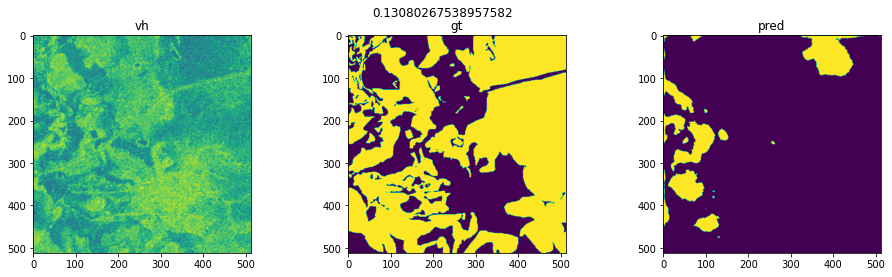

In [ ]:
plot_preds()

# 6. Prepare for Submission

## 6.1. Create a local `benchmark-pytorch/` directory 

Add a `benchmark-pytorch/assets` subdirectory to store our trained model and weights.

In [ ]:
# Create directory and subdirectory

submission_path = Path("benchmark-pytorch")
submission_path.mkdir(exist_ok=True)
submission_assets_path = submission_path / "assets"
submission_assets_path.mkdir(exist_ok=True)

In Pytorch, the learnable parameters of a model including its weights and biases are contained in it's parameters. A `state_dict` is a Python dictionary object that maps each layer to its parameter tensor. PyTorch provides a handy `model.save()` method for serializing our model's `state_dict` and, in turn, saving our model's weights.

In [ ]:
# Save trained model and weights

weight_path = submission_assets_path / "flood_model.pt"
torch.save(flood_model.state_dict(), weight_path)

## 6.2. Create Model Class for Inference and `main.py` to Perform Inference

We'll be performing inference on the images sotred in `data/test_features`, generate chip-level predictions, and save predictions to `submission/`.

To load our trained model in the competition runtime environment, we'll save a simplified `FloodModel` class to `benchmark-pytorch/flood_model.py`. This model class will instantiate a generic U-Net model and will contain a helper method to perform inference for a given chip.

Let's start by creating a script with our PyTorch Lightning model so that we can import it in `main.py` and use it for inference.

In [ ]:
%%file benchmark-pytorch/flood_model.py
import numpy as np
import pytorch_lightning as pl
import rasterio
import segmentation_models_pytorch as smp
import torch


class FloodModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=2,
            classes=2,
        )

    def forward(self, image):
        # Forward pass
        return self.model(image)

    def predict(self, vv_path, vh_path):
        # Switch on evaluation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Create a 2-channel image
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        x_arr = np.stack([vv_img, vh_img], axis=-1)

        # Min-max normalization
        min_norm = -77
        max_norm = 26
        x_arr = np.clip(x_arr, min_norm, max_norm)
        x_arr = (x_arr - min_norm) / (max_norm - min_norm)

        # Transpose
        x_arr = np.transpose(x_arr, [2, 0, 1])
        x_arr = np.expand_dims(x_arr, axis=0)

        # Perform inference
        preds = self.forward(torch.from_numpy(x_arr))
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1
        return preds.detach().numpy().squeeze().squeeze()

Writing benchmark-pytorch/flood_model.py


Now, let's create our `main.py` file to do inference and save our predictions.

This `main.py` file will be placed in the root of our `benchmark-pytorch/` directory since that is what is needed when we package everything to do inference and submit it for a containerized execution. In other words, we aren't simply doing inference on a set of downloaded images; we are saving our model and inference scripts and submitting that in order to do inference.

In [ ]:
%%file benchmark-pytorch/main.py
import os
from pathlib import Path

from loguru import logger
import numpy as np
from tifffile import imwrite
from tqdm import tqdm
import torch
import typer

from flood_model import FloodModel


ROOT_DIRECTORY = Path("/codeexecution")
SUBMISSION_DIRECTORY = ROOT_DIRECTORY / "submission"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Make sure the smp loader can find our torch assets because we don't have internet!
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "torch")


def make_prediction(chip_id, model):
    """
    Given a chip_id, read in the vv/vh bands and predict a water mask.

    Args:
        chip_id (str): test chip id

    Returns:
        output_prediction (arr): prediction as a numpy array
    """
    logger.info("Starting inference.")
    try:
        vv_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vv.tif"
        vh_path = INPUT_IMAGES_DIRECTORY / f"{chip_id}_vh.tif"
        output_prediction = model.predict(vv_path, vh_path)
    except Exception as e:
        logger.error(f"No bands found for {chip_id}. {e}")
        raise
    return output_prediction


def get_expected_chip_ids():
    """
    Use the test features directory to see which images are expected.
    """
    paths = INPUT_IMAGES_DIRECTORY.glob("*.tif")
    # Return one chip id per two bands (VV/VH)
    ids = list(sorted(set(path.stem.split("_")[0] for path in paths)))
    return ids


def main():
    """
    For each set of two input bands, generate an output file
    using the `make_predictions` function.
    """
    logger.info("Loading model")
    # Explicitly set where we expect smp to load the saved resnet from just to be sure
    torch.hub.set_dir(ASSETS_DIRECTORY / "torch/hub")
    model = FloodModel()
    model.load_state_dict(torch.load(ASSETS_DIRECTORY / "flood_model.pt"))

    logger.info("Finding chip IDs")
    chip_ids = get_expected_chip_ids()
    if not chip_ids:
        typer.echo("No input images found!")
        raise typer.Exit(code=1)

    logger.info(f"Found {len(chip_ids)} test chip_ids. Generating predictions.")
    for chip_id in tqdm(chip_ids, miniters=25):
        output_path = SUBMISSION_DIRECTORY / f"{chip_id}.tif"
        output_data = make_prediction(chip_id, model).astype(np.uint8)
        imwrite(output_path, output_data, dtype=np.uint8)

    logger.success(f"Inference complete.")


if __name__ == "__main__":
    typer.run(main)

Writing benchmark-pytorch/main.py


In [ ]:
!cp -R ~/.cache/torch benchmark-pytorch/assets/

In [ ]:
!tree benchmark-pytorch/

/bin/bash: tree: command not found


In [ ]:
# Remember to avoid including the inference dir itself
!cd benchmark-pytorch && zip -r ../submission.zip *

  adding: assets/ (stored 0%)
  adding: assets/flood_model.pt (deflated 7%)
  adding: assets/torch/ (stored 0%)
  adding: assets/torch/hub/ (stored 0%)
  adding: assets/torch/hub/checkpoints/ (stored 0%)
  adding: assets/torch/hub/checkpoints/resnet34-333f7ec4.pth (deflated 7%)
  adding: flood_model.py (deflated 58%)
  adding: main.py (deflated 57%)


In [ ]:
!du -h submission.zip

164M	submission.zip
